# In this notebook, a VAE is trained and used to generate new samples

In [1]:
import utils_ML as uml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, normalize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from imblearn.combine import SMOTEENN, SMOTETomek

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

device = 'cuda' if torch.cuda.is_available() else "cpu"

In [4]:
architecture_results = pd.read_csv("../ML/results/VAE_architecture_search.csv", index_col = "Unnamed: 0")

In [14]:
architecture_results

1  \
latent_dim                                                      10   
hidden_dim                                                     100   
lr                                                          0.0001   
train_loss       [582.27270618117, 549.9763860128012, 523.32766...   
validation_loss  [545.4193638392857, 516.6368858700707, 493.151...   

                                                                 2  \
latent_dim                                                      10   
hidden_dim                                                     100   
lr                                                           0.001   
train_loss       [372.2821015507342, 359.6169481392366, 352.442...   
validation_loss  [358.04017057872954, 367.06779407319567, 373.1...   

                                                                 3  \
latent_dim                                                      10   
hidden_dim                                                     100   
lr                                                            0.01   
train_loss       [531.041937402932, 471.19771235822196, 473.071...   
validation_loss  [471.8666251046317, 441.087161109561, 467.6989...   

                                                                 4  \
latent_dim                                                      10   
hidden_dim                                                     300   
lr                                                          0.0001   
train_loss       [554.5411880677005, 500.0313290515578, 483.126...   
validation_loss  [500.2240644182478, 471.86385672433033, 461.85...   

                                                                 5  \
latent_dim                                                      10   
hidden_dim                                                     300   
lr                                                           0.001   
train_loss       [357.66072836266943, 328.9365565288498, 326.91...   
validation_loss  [334.1520487467448, 334.794436500186, 339.9416...   

                                                                 6  \
latent_dim                                                      10   
hidden_dim                                                     300   
lr                                                            0.01   
train_loss       [542.9417287068195, 454.77606936535204, 461.28...   
validation_loss  [458.7727980840774, 427.5330548967634, 446.821...   

                                                                 7  \
latent_dim                                                      10   
hidden_dim                                                     500   
lr                                                          0.0001   
train_loss       [534.0656642684017, 484.655613910721, 474.5377...   
validation_loss  [476.4514349074591, 461.616452171689, 450.0166...   

                                                                 8  \
latent_dim                                                      10   
hidden_dim                                                     500   
lr                                                           0.001   
train_loss       [346.3470229183335, 321.89334345438397, 322.98...   
validation_loss  [326.4983505975632, 319.6622910272507, 326.589...   

                                                                 9  \
latent_dim                                                      10   
hidden_dim                                                     500   
lr                                                            0.01   
train_loss       [569.9270795339561, 473.21146107868975, 471.43...   
validation_loss  [457.04832531156995, 453.66216459728423, 449.8...   

                                                                10  ...  \
latent_dim                                                      10  ...   
hidden_dim                                                     700  ...   
lr                                                 

In [29]:
val_losses = {}
for col_i in architecture_results.columns:
    param = str("LD-") + str(architecture_results.loc["latent_dim", col_i]) 
    param += str(" HD-") + str(architecture_results.loc["hidden_dim", col_i]) + str(" LR-") + str(architecture_results.loc["lr", col_i])
    val_losses[param] = [float(x) for x in architecture_results.loc["validation_loss", col_i][1:-2].split(", ")]

In [30]:
val_table = pd.DataFrame(val_losses)

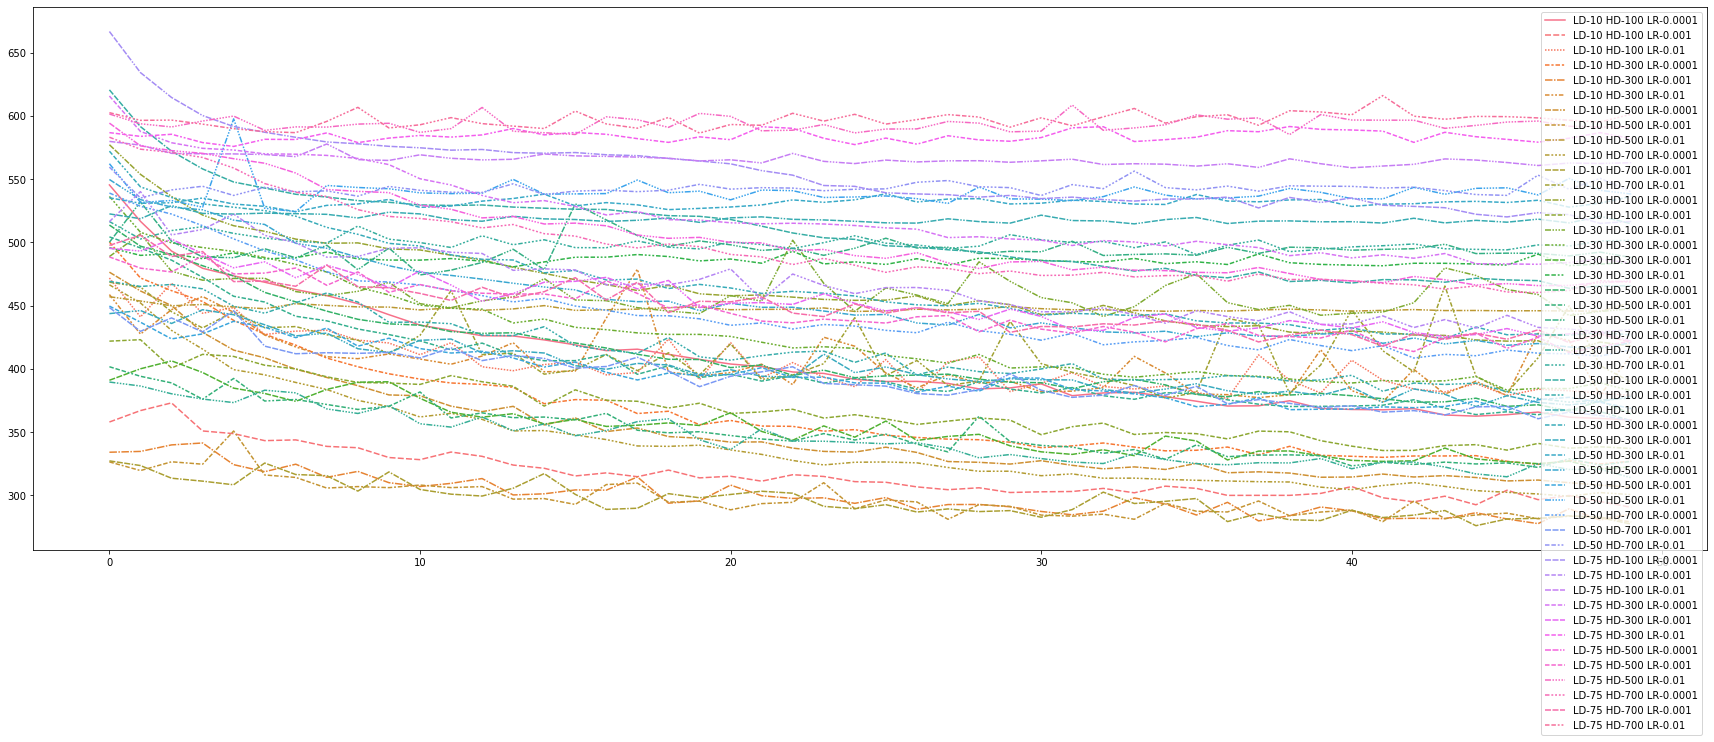

In [31]:
plt.figure(figsize=(30,10))
sns.lineplot(data=val_table)

In [32]:
val_table.min().sort_values()

LD-10 HD-700 LR-0.001     276.088840
LD-10 HD-300 LR-0.001     277.715976
LD-10 HD-500 LR-0.001     279.016688
LD-10 HD-100 LR-0.001     290.620553
LD-10 HD-700 LR-0.0001    299.344672
LD-10 HD-500 LR-0.0001    306.535636
LD-30 HD-700 LR-0.001     313.962876
LD-30 HD-300 LR-0.001     321.070641
LD-30 HD-500 LR-0.001     322.137310
LD-10 HD-300 LR-0.0001    324.577663
LD-30 HD-100 LR-0.001     335.508363
LD-30 HD-700 LR-0.0001    359.001729
LD-50 HD-700 LR-0.001     359.123419
LD-10 HD-100 LR-0.0001    359.688926
LD-30 HD-500 LR-0.0001    364.305641
LD-50 HD-500 LR-0.001     367.277270
LD-50 HD-300 LR-0.001     370.237427
LD-50 HD-100 LR-0.001     373.746357
LD-10 HD-300 LR-0.01      373.879193
LD-10 HD-100 LR-0.01      376.567204
LD-10 HD-700 LR-0.01      376.946674
LD-30 HD-300 LR-0.0001    382.687420
LD-50 HD-700 LR-0.0001    408.596680
LD-75 HD-500 LR-0.001     412.957322
LD-30 HD-100 LR-0.0001    413.767171
LD-50 HD-500 LR-0.0001    416.274683
LD-75 HD-700 LR-0.001     417.923350
L

In [1]:
import wandb
wandb.init(project = "VAE-")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sam-vanpuyenbroeck (savpuyen). Use `wandb login --relogin` to force relogin


: 

: 

In [6]:
# Load datasets
data_combat = pd.read_csv("../preprocessing/combat_NSAF_50.csv", index_col = "assay_id")
data_quantile = pd.read_csv("../preprocessing/quantile_norm_NSAF_50.csv", index_col = "assay_id")
data_median_norm = pd.read_csv("../preprocessing/median_scaling_50.csv", index_col = "Unnamed: 0")
data_nsaf = pd.read_csv("../preprocessing/NSAF_50.csv", index_col = "assay_id")
data_nsaf = np.log2(data_nsaf)

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data_combat.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data_combat.sort_index(inplace=True)
data_quantile.sort_index(inplace=True)
data_median_norm.sort_index(inplace=True)
data_nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

missing_value_mask = data_nsaf.isna()
data_combat = data_combat.where(~missing_value_mask, other=np.nan)

data_combat = data_combat.reset_index(drop=True).rename(columns={data_combat.columns[x]:x for x in range(len(data_combat.columns))})
data_quantile = data_quantile.reset_index(drop=True).rename(columns={data_quantile.columns[x]:x for x in range(len(data_quantile.columns))})
data_median_norm = data_median_norm.reset_index(drop=True).rename(columns={data_median_norm.columns[x]:x for x in range(len(data_median_norm.columns))})
data_nsaf = data_nsaf.reset_index(drop=True).rename(columns={data_nsaf.columns[x]:x for x in range(len(data_nsaf.columns))})

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [17]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, num_features, hidden_features):
        super(VariationalEncoder, self).__init__()

        self.linear1 = nn.Linear(num_features, hidden_features)
        self.linear2 = nn.Linear(hidden_features, latent_dims)
        self.linear3 = nn.Linear(hidden_features, latent_dims)

        self.N = torch.distributions.Normal(0,1)
        self.kl = 0

        # Add regularization with dropouts
        #self.dropout = nn.Dropout(0.25) # approximately 250 neurons will be deactivated

    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        x = self.linear1(x)
        x = F.relu(x)
        #x = self.dropout(x)

        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))

        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims, num_features, hidden_features):
        super(Decoder, self).__init__()
        
        self.linear1 = nn.Linear(latent_dims, hidden_features)
        self.linear2 = nn.Linear(hidden_features, num_features)
        #self.dropout = nn.Dropout(0.25)

    def forward(self, z):
        z = self.linear1(z)
        z = F.relu(z)

        #z = self.dropout(z)

        z = self.linear2(z)
        z = torch.sigmoid(z)

        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, num_features, hidden_features):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = VariationalEncoder(latent_dims, num_features, hidden_features)
        self.decoder = Decoder(latent_dims, num_features, hidden_features)

    def forward(self, x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)

        return reconstruction
    
def trainVAE(autoencoder: VariationalAutoencoder, data, epochs = 20):
    optimization = torch.optim.Adam(autoencoder.parameters())

    running_loss = 0
    last_loss = 0

    for epoch in range(epochs):
        print(epoch)

        for i, x in enumerate(data):
            x = x.to(device)
            optimization.zero_grad()
            x_hat = autoencoder(x)

            loss = ((x-x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            optimization.step()
        
            running_loss += loss.item()

            if i == 129:
                last_loss = running_loss/129
                print('batch {} loss: {}'.format(i + 1, last_loss))

                running_loss = 0
        print(loss)
    return autoencoder

def trainDVAE2(autoencoder: VariationalAutoencoder, data, validation_data=False, epochs = 20, lr=.001):
    optimization = torch.optim.Adam(autoencoder.parameters(), lr = lr)

    training_losses = []
    validation_losses = []

    running_loss = 0
    last_loss = 0

    for epoch in range(epochs):

        for label, (x_1, x_2) in data:

            x_1 = x_1.to(device)
            optimization.zero_grad()

            x1_hat = autoencoder(x_1)
            x2_hat = autoencoder(x_2)

            reconstruction_error = ((x_1-x1_hat)**2).sum() # Reconstructed datapoint must be similar
            intra_class_difference_error = ((x1_hat-x2_hat)**2).sum() # Incentivize class identity reconstruction by using other samples from the same class
            kullback_leibler = autoencoder.encoder.kl # Error term to ensure a smooth latent space

            loss = (reconstruction_error + intra_class_difference_error)/2 + kullback_leibler
            loss.backward()
            optimization.step()

            running_loss += loss.item()

        last_loss = running_loss / len(data)
        print('  epoch {} loss: {}'.format(epoch, last_loss))
        training_losses.append(last_loss)
        
        running_loss = 0
        valid_loss = 0

        if validation_data == False:
            continue

        for label, (x_1, x_2) in validation_data:

            x1_hat = autoencoder(x_1)
            x2_hat = autoencoder(x_2)
            
            reconstruction_error = ((x_1-x1_hat)**2).sum() 
            intra_class_difference_error = ((x1_hat-x2_hat)**2).sum()
            kullback_leibler = autoencoder.encoder.kl

            loss = (reconstruction_error + intra_class_difference_error)/2 + kullback_leibler

            valid_loss += loss.item()
        
        valid_loss = valid_loss/len(validation_data)
        print('     Validation loss: {}\n'.format(valid_loss))
        validation_losses.append(valid_loss)

    return autoencoder, training_losses, validation_losses

In [18]:
class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, targets):
        self.dataset = dataset
        self.targets = targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image1 = self.dataset[index]
        label1 = self.targets[index]
        
        while True:
            index2 = torch.randint(len(self.dataset), size=(1,)).item()
            image2, label2 = self.dataset[index2], self.targets[index2]
            if label2 == label1 and index != index2:
                break

        return label1, (image1, image2)

In [14]:
imputer = uml.MNAR_MCAR_Imputer(max_iter=15)
imputer.fit(data_combat, targets)
imputed_combat = imputer.transform(data_combat, targets)

First iteration: 0
iteration: 0
Components: 357
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14


In [32]:
imputed_combat_ = imputed_combat.astype('float32').to_numpy()
X_train, X_test, y_train, y_test = train_test_split(imputed_combat_, targets, test_size=0.20, random_state=42, stratify=targets)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


train_paired_dataset = PairedDataset(X_train, y_train)
test_paired_dataset = PairedDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_paired_dataset, batch_size=5, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_paired_dataset, batch_size=5, shuffle=True)

In [35]:
latent_dims_k = [5, 10, 20, 30, 50]
hidden_dims_k = [100,200,300,400,500]
learning_rates = [.0001, .001, .01,.1]

VAEs = {}
results = {}
counts = 0
for latent_dim in latent_dims_k:
    for hidden_dim in hidden_dims_k:
        vae = VariationalAutoencoder(latent_dims = latent_dim, num_features=2615, hidden_features=hidden_dim)
        for lr in learning_rates:
            counts+= 1
            print(counts, ":", latent_dim, hidden_dim, lr)

            fitted_vae, train_loss, validation_loss = trainDVAE2(vae, train_loader, validation_data=test_loader, epochs = 50, lr = lr)
            results[counts] = {"latent_dim": latent_dim, "hidden_dim": hidden_dim, "lr": lr, "train_loss": train_loss, "validation_loss": validation_loss}

            VAEs[counts] = fitted_vae

1 : 5 100 0.0001
  epoch 0 loss: 257.1272901052452
     Validation loss: 246.55233401343935

  epoch 1 loss: 239.55361846556147
     Validation loss: 231.72843061174666

  epoch 2 loss: 226.07112967249859
     Validation loss: 219.82005746023995

  epoch 3 loss: 216.10218498505742
     Validation loss: 214.30922081356957

  epoch 4 loss: 210.43158914956703
     Validation loss: 209.35887145996094

  epoch 5 loss: 206.327298451619
     Validation loss: 205.6323965163458

  epoch 6 loss: 203.69693360845727
     Validation loss: 203.33075459798178

  epoch 7 loss: 201.3634777758495
     Validation loss: 202.08838980538505

  epoch 8 loss: 200.122314453125
     Validation loss: 200.88106863839286

  epoch 9 loss: 198.43789489010732
     Validation loss: 199.63193693615142

  epoch 10 loss: 197.35625522107964
     Validation loss: 198.62159293038505

  epoch 11 loss: 196.83028990963857
     Validation loss: 199.0586431594122

  epoch 12 loss: 196.07183323136294
     Validation loss: 197.032

In [ ]:
num_features = processed_data.shape[1]
all_data_vae = VariationalAutoencoder(latent_dims=50, num_features=num_features).to(device)

---

In [29]:
# read data

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

data = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()

class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [30]:
preprocessor = Pipeline(steps=[
    ('filtering', uml.FilterByClass(keep=True, percentage=.7)),
    ('imputation', uml.LowestValueImputer())
])

preprocessor.fit(data, targets)

processed_data = preprocessor.transform(data)
processed_data = processed_data.astype('float32')

processed_data_df = pd.DataFrame(processed_data, columns = preprocessor.named_steps.filtering.filtered_proteins, index=data.index)

processed_data_df.shape

(518, 6887)

In [49]:
full_dataset = PairedDataset(processed_data, targets)
full_dataset_loader = torch.utils.data.DataLoader(full_dataset, batch_size=15, shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(processed_data, targets, test_size=0.20, random_state=42, stratify=targets)

train_paired_dataset = PairedDataset(X_train, y_train)
test_paired_dataset = PairedDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_paired_dataset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_paired_dataset, batch_size=5, shuffle=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.20, random_state=42, stratify=targets)

preprocessor.fit(X_train, y_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

train_paired_dataset = PairedDataset(X_train, y_train)
test_paired_dataset = PairedDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_paired_dataset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_paired_dataset, batch_size=5, shuffle=True)

In [7]:
def decodeBatch(vae, encodings):
    '''Return reconstructed samples given some encodings'''
    
    encodings = torch.utils.data.DataLoader(encodings, batch_size=1, shuffle=False)

    flag = True
    for encoding in encodings:
        if flag:
            reconstructed = vae.decoder(encoding).detach().numpy()[0]
            flag = False
            continue
        reconstructed = np.vstack([reconstructed, vae.decoder(encoding).detach().numpy()[0]])

    return reconstructed


def useVAE(vae, data):
    """
    Returns encodings and reconstructed data

    Accepts a numpy array as data and an autoencoder
    """
    input_data = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)

    flag = True
    for datapoint in input_data:
        
        encoding = vae.encoder(datapoint)
        if flag:
            encodings = encoding.detach().numpy()[0]
            reconstructed = vae.decoder(encoding).detach().numpy()[0]
            flag = False

            continue

        encodings = np.vstack([encodings, encoding.detach().numpy()[0]])
        reconstructed = np.vstack([reconstructed, vae.decoder(encoding).detach().numpy()[0]])

    return encodings, reconstructed

def SampleVAE(vae, samples, n):
    """
    Generate n samples of the samples provided with vae (generates n-times in the given order [sample1, sample2, ..., sample-n, sample1, sample2...,sample-n])

    Returns encodings and reconstructed sample
    """
    sampler = []
    for i in range(n):
        for sample in samples:
            sampler.append(sample)

    sampler = torch.utils.data.DataLoader(sampler, batch_size=1, shuffle=False)

    flag = True
    for sample in sampler:
        
        encoding = vae.encoder(sample)
        if flag:
            encodings = encoding.detach().numpy()[0]
            reconstructed = vae.decoder(encoding).detach().numpy()[0]
            flag = False
            continue
        
        encodings = np.vstack([encodings, encoding.detach().numpy()[0]])
        reconstructed = np.vstack([reconstructed, vae.decoder(encoding).detach().numpy()[0]])
    
    return encodings, reconstructed

# Denoising Variational autoencoder

In [50]:
num_features = processed_data.shape[1]
all_data_vae = VariationalAutoencoder(latent_dims=50, num_features=num_features).to(device)

In [51]:
all_data_vae, train_loss, _ = trainDVAE2(all_data_vae, full_dataset_loader, validation_data=False, epochs = 100) 

KeyError: 292

In [ ]:
encodings_full, reconstructed_full = useVAE(all_data_vae, processed_data)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

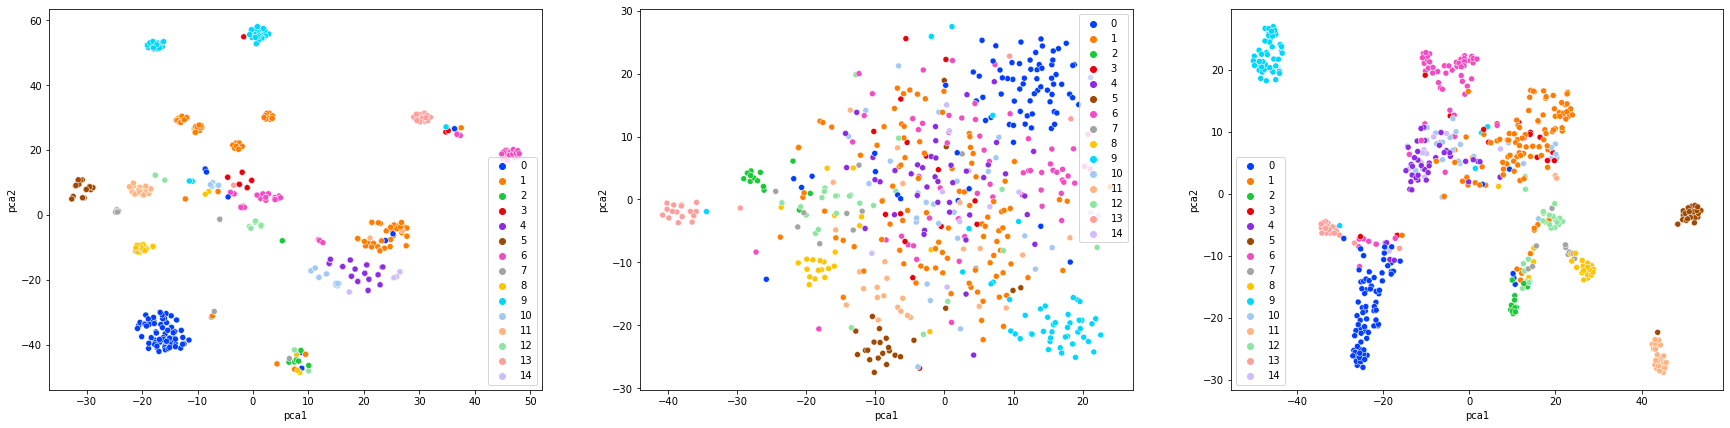

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(30,7))

pca = TSNE(perplexity=20)

embeddings = pca.fit_transform(processed_data)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = targets, ax=ax[0], palette=colors)

embeddings = pca.fit_transform(encodings_full)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = targets, ax=ax[1], palette=colors)

embeddings = pca.fit_transform(reconstructed_full)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = targets, ax=ax[2], palette=colors)

In [ ]:
proc = pd.DataFrame(processed_data)
rec = pd.DataFrame(reconstructed_full)

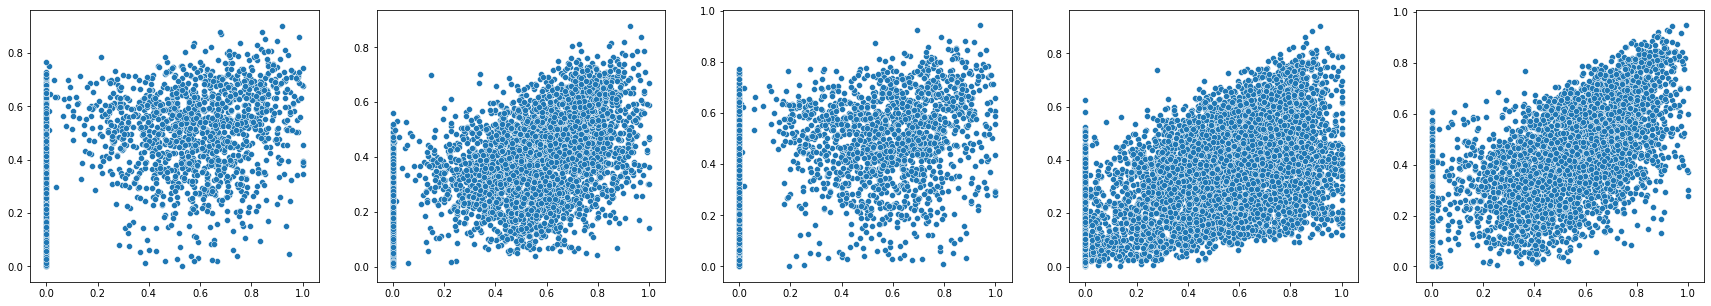

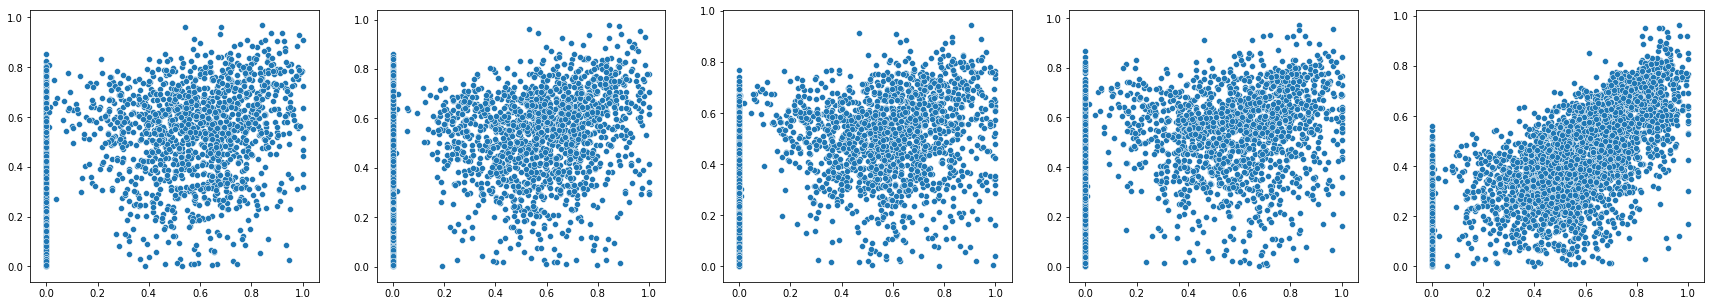

In [ ]:
# upper: comparisons between samples
# lower: comparisons sample and reconstruction

indices = proc.iloc[targets==9,:].index.tolist()

fig, ax = plt.subplots(1,5, figsize=(30,5))
for i,x in enumerate(np.random.choice(indices,5)):
    sns.scatterplot(x=proc.iloc[x,:].tolist(), y =rec.iloc[x,:].tolist(), ax=ax[i])

fig, ax = plt.subplots(1,5, figsize=(30,5))
for i,x in enumerate(np.random.choice(indices,5)):
    sns.scatterplot(x=proc.iloc[indices[i],:].tolist(), y =rec.iloc[indices[i+5],:].tolist(), ax=ax[i])

In [9]:
X_train.shape

(414, 7267)

In [ ]:
# No data leakage with preprocessing
num_features = X_train.shape[1]
vae = VariationalAutoencoder(latent_dims=50, num_features=num_features).to(device)

# 2 samples of the same class are needed to compute the reconstruction error. Validation is done by checking how the test samples are reconstructed
denoising_vae, train_loss, test_loss = trainDVAE2(vae, train_loader, validation_data=test_loader, epochs = 200) 

In [6]:
splitter = uml.ProjectBasedSplit(10, metadata=meta, on="Group")

fold=0

vaes = []
X_train_pxds = []
X_test_pxds = []

Y_train_pxds = []
Y_test_pxds = []

train_losses = []
test_losses = []

dropped_projects = []

for train, test in splitter.split(data, None):
    
    fold += 1
    print(fold)
    # Split data
    X_train_pxd = data.iloc[train,:]
    Y_train_pxd = targets[train]
    X_test_pxd = data.iloc[test,:]
    Y_test_pxd = targets[test]

    preprocessor.fit(X_train_pxd, Y_train_pxd)
    X_train_preprocessed_pxd = preprocessor.transform(X_train_pxd)
    X_test_preprocessed_pxd = preprocessor.transform(X_test_pxd)

    X_train_preprocessed_pxd = X_train_preprocessed_pxd.astype('float32')
    X_test_preprocessed_pxd = X_test_preprocessed_pxd.astype('float32')

    train_paired_dataset = PairedDataset(X_train_preprocessed_pxd, Y_train_pxd)
    test_paired_dataset = PairedDataset(X_test_preprocessed_pxd, Y_test_pxd)

    train_loader = torch.utils.data.DataLoader(train_paired_dataset, batch_size=10, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_paired_dataset, batch_size=5, shuffle=True)

    input_shape = X_train_preprocessed_pxd.shape[1]
    vae = VariationalAutoencoder(latent_dims=50, num_features=input_shape).to(device)

    pxd_denoising_vae, train_loss_pxd, test_loss_pxd = trainDVAE2(vae, train_loader, validation_data=False, epochs = 100)

    vaes.append(pxd_denoising_vae)
    train_losses.append(train_loss_pxd)
    test_losses.append(test_loss_pxd)

    X_train_pxds.append(X_train_preprocessed_pxd)
    X_test_pxds.append(X_test_preprocessed_pxd)

    Y_train_pxds.append(Y_train_pxd)
    Y_test_pxds.append(Y_test_pxd)

    dropped_projects.append(splitter.dropped_pxds[-1])

1
  epoch 0 loss: 2910.6386121961805
  epoch 1 loss: 2319.7953504774305
  epoch 2 loss: 2278.6031060112846
  epoch 3 loss: 2255.334516059028
  epoch 4 loss: 2223.3655598958335
  epoch 5 loss: 2191.1431559244793
  epoch 6 loss: 2171.2950086805554
  epoch 7 loss: 2162.9075222439237
  epoch 8 loss: 2171.038614908854
  epoch 9 loss: 2151.888951280382
  epoch 10 loss: 2127.729012044271
  epoch 11 loss: 2147.5706244574653
  epoch 12 loss: 2100.8763916015623
  epoch 13 loss: 2104.609597439236
  epoch 14 loss: 2100.2894585503473
  epoch 15 loss: 2064.6712429470485
  epoch 16 loss: 2074.9822781032985
  epoch 17 loss: 2052.294935438368
  epoch 18 loss: 2063.42421875
  epoch 19 loss: 2046.5112874348958
  epoch 20 loss: 2047.973006184896
  epoch 21 loss: 2066.333376736111
  epoch 22 loss: 2045.7001220703125
  epoch 23 loss: 2118.4639892578125
  epoch 24 loss: 2048.5955919053818
  epoch 25 loss: 2082.200949435764
  epoch 26 loss: 2039.6386773003471
  epoch 27 loss: 2048.811406792535
  epoch 28 loss

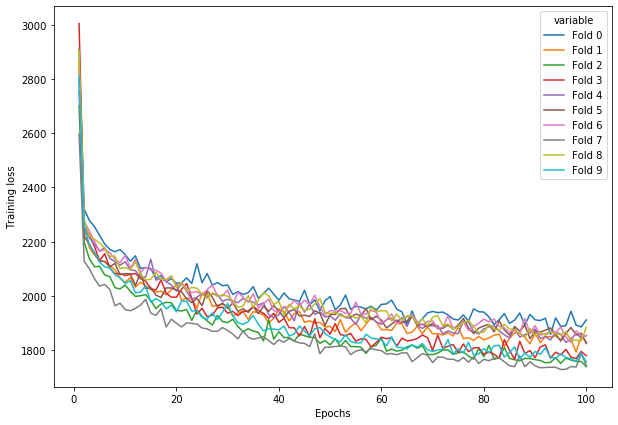

In [25]:
train_losses_ = pd.DataFrame(train_losses).T
train_losses_["Epoch"] = list(range(1, 101))

train_losses_ = train_losses_.rename(columns={x:"Fold "+str(x) for x in range(10)})

fig, (ax1) = plt.subplots(1,1, figsize=(10,7))

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training loss")
sns.lineplot(data=train_losses_.melt(id_vars = "Epoch"), x='Epoch', y = "value", hue="variable", ax=ax1)

In [26]:
dropped_projects

[['PXD007759', 'PXD010538', 'PXD001468', 'PXD009442', 'PXD008222'],
 ['PXD004452', 'PXD003407', 'PXD007759', 'PXD018450', 'PXD001352'],
 ['PXD018066', 'PXD005940', 'PXD000533', 'PXD008222', 'PXD003407'],
 ['PXD001352', 'PXD004452', 'PXD018450', 'PXD005940', 'PXD008222'],
 ['PXD003530', 'PXD000426', 'PXD002842', 'PXD001468', 'PXD016742'],
 ['PXD003407', 'PXD006591', 'PXD000533', 'PXD001352', 'PXD010538'],
 ['PXD001352', 'PXD000426', 'PXD010538', 'PXD005940', 'PXD004900'],
 ['PXD004452', 'PXD007759', 'PXD008381', 'PXD000443', 'PXD000529'],
 ['PXD004452', 'PXD000443', 'PXD003406', 'PXD003790', 'PXD018450'],
 ['PXD004452', 'PXD003252', 'PXD005940', 'PXD008381', 'PXD008222']]

In [29]:
encodings_train_list, reconstructed_train_list = [], []
encodings_test_list, reconstructed_test_list = [], []

for x in range(10):

    encodings_train, reconstructed_train = useVAE(vaes[x], X_train_pxds[x])
    encodings_test, reconstructed_test = useVAE(vaes[x], X_test_pxds[x])

    encodings_train_list.append(encodings_train)
    encodings_test_list.append(encodings_test)
    reconstructed_train_list.append(reconstructed_train)
    reconstructed_test_list.append(reconstructed_test)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

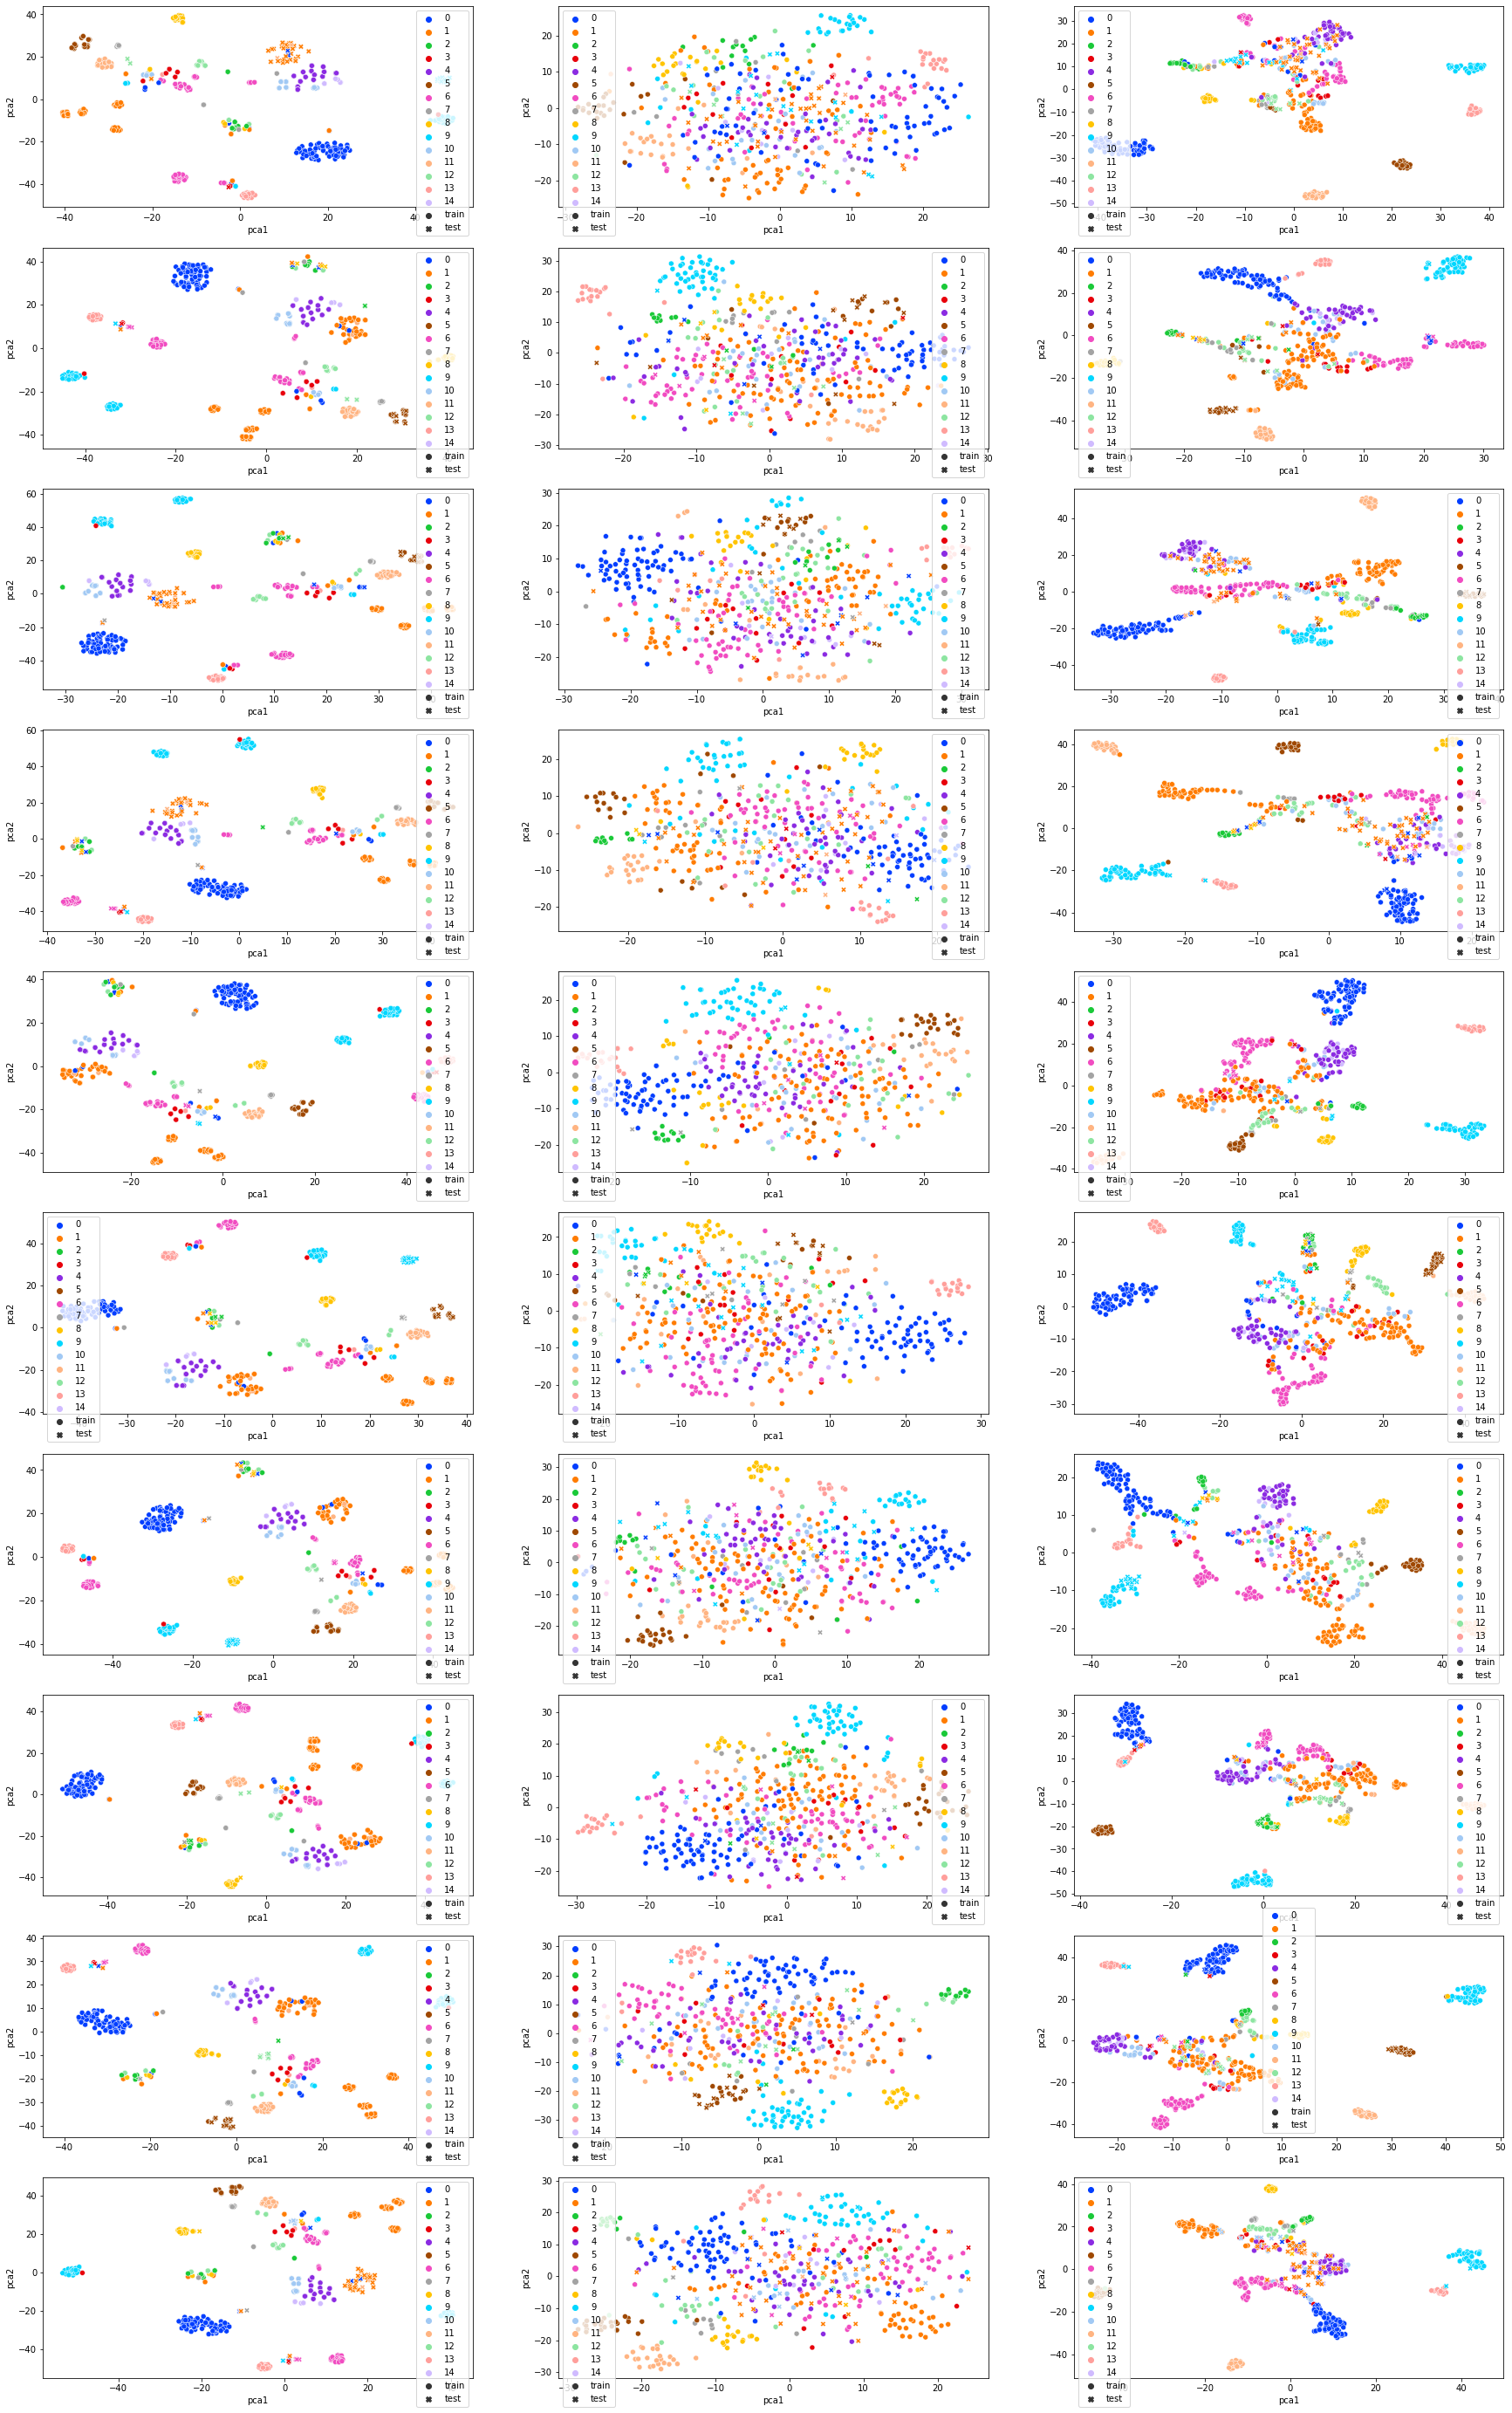

In [32]:
fig, ax = plt.subplots(10,3, figsize=(30,50))

for x in range(10):

    pca = TSNE(perplexity=20)

    embeddings = pca.fit_transform(pd.concat([pd.DataFrame(X_train_pxds[x]), pd.DataFrame(X_test_pxds[x])]))
    sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = list(Y_train_pxds[x]) + list(Y_test_pxds[x]) , ax=ax[x][0], palette=colors, style = ["train"]*len(Y_train_pxds[x])+["test"]*len(Y_test_pxds[x]))

    embeddings = pca.fit_transform(pd.concat([pd.DataFrame(encodings_train_list[x]), pd.DataFrame(encodings_test_list[x])]))
    sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = list(Y_train_pxds[x]) + list(Y_test_pxds[x]) , ax=ax[x][1], palette=colors, style = ["train"]*len(Y_train_pxds[x])+["test"]*len(Y_test_pxds[x]))

    embeddings = pca.fit_transform(pd.concat([pd.DataFrame(reconstructed_train_list[x]), pd.DataFrame(reconstructed_test_list[x])]))
    sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = list(Y_train_pxds[x]) + list(Y_test_pxds[x]) , ax=ax[x][2], palette=colors, style = ["train"]*len(Y_train_pxds[x])+["test"]*len(Y_test_pxds[x]))


In [32]:
vae = VariationalAutoencoder(latent_dims=50).to(device)

# 2 samples of the same class are needed to compute the reconstruction error. Validation is done by checking how the test samples are reconstructed
denoising_vae, train_loss, test_loss = trainDVAE2(vae, train_loader, validation_data=test_loader, epochs = 200) 

  epoch 0 loss: 2864.7550252278647
     Validation loss: 1138.5729021344866

  epoch 1 loss: 2287.9886096772693
     Validation loss: 1113.4476318359375

  epoch 2 loss: 2217.1688217889696
     Validation loss: 1112.7994326636904

  epoch 3 loss: 2217.8581107003347
     Validation loss: 1109.0712280273438

  epoch 4 loss: 2194.350507463728
     Validation loss: 1124.1976202101935

  epoch 5 loss: 2163.4256911504835
     Validation loss: 1151.0283377511162

  epoch 6 loss: 2169.570234026228
     Validation loss: 1066.5549490792412

  epoch 7 loss: 2162.6513671875
     Validation loss: 1079.9034976050966

  epoch 8 loss: 2158.1932431175596
     Validation loss: 1062.6802862258185

  epoch 9 loss: 2131.9126325334823
     Validation loss: 1068.7430419921875

  epoch 10 loss: 2075.9461858840214
     Validation loss: 1097.814229329427

  epoch 11 loss: 2082.953839983259
     Validation loss: 1099.6865844726562

  epoch 12 loss: 2078.319651285807
     Validation loss: 1038.5360775902159

  ep

In [ ]:
plt.figure(figsize=(15,6))

scores= pd.DataFrame({'training': train_loss}).melt()
scores = pd.concat([pd.Series(list(range(1,160))), scores], axis=1).rename(columns={0:"epoch", "value": "loss"})
sns.lineplot(data=scores, x="epoch", y = "loss", hue="variable")

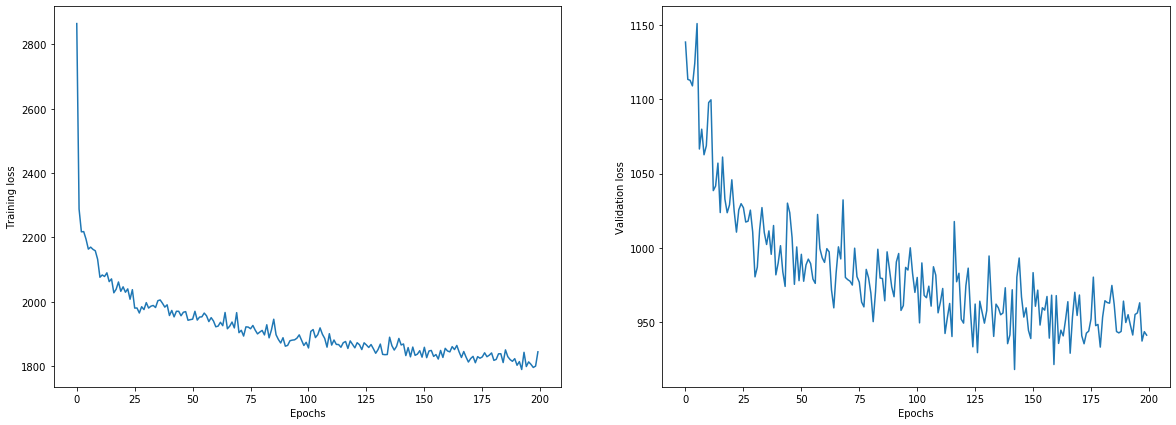

In [39]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,7))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training loss")
sns.lineplot(y=train_loss, x=list(range(200)), ax=ax1)

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Validation loss")
sns.lineplot(y=test_loss, x=list(range(200)), ax=ax2)

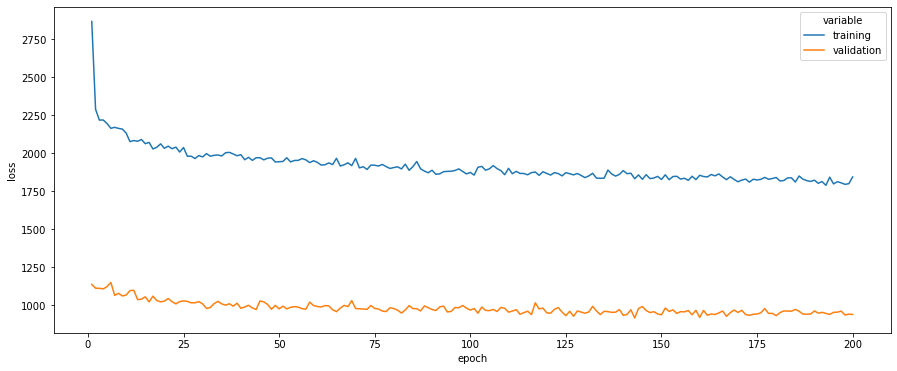

In [34]:
plt.figure(figsize=(15,6))

scores= pd.DataFrame({'training': train_loss, 'validation': test_loss}).melt()
scores = pd.concat([pd.Series(list(range(1,201))*2), scores], axis=1).rename(columns={0:"epoch", "value": "loss"})
sns.lineplot(data=scores, x="epoch", y = "loss", hue="variable")

In [42]:
encodings_train, reconstructed_train = useVAE(denoising_vae, X_train)

In [48]:
og_and_recon = pd.concat([pd.DataFrame(X_train), pd.DataFrame(reconstructed_train)])

0         1         2         3         4         5         6     \
0    0.000000  0.647525  0.000000  0.684642  0.787645  0.000000  0.000000   
1    0.000000  0.745792  0.000000  0.147176  0.412195  0.000000  0.684855   
2    0.297229  0.665400  0.000000  0.742537  0.365388  0.000000  0.020755   
3    0.000000  0.907834  0.000000  0.000000  0.420895  0.000000  0.000000   
4    0.000000  0.760128  0.000000  0.879300  0.000000  0.000000  0.476382   
..        ...       ...       ...       ...       ...       ...       ...   
409  0.014868  0.650171  0.000518  0.488470  0.403290  0.001198  0.210273   
410  0.010332  0.472358  0.007713  0.341497  0.353008  0.010371  0.082689   
411  0.014370  0.699598  0.008547  0.453679  0.510069  0.004155  0.331605   
412  0.065710  0.598124  0.014793  0.410158  0.404465  0.051308  0.115619   
413  0.049321  0.641044  0.011858  0.460743  0.467353  0.027007  0.209496   

         7         8         9     ...      6877      6878      6879  \
0    0.000000  0.242978  0.000000  ...  0.000000  0.600013  0.595815   
1    0.599700  0.452930  0.705200  ...  0.000000  0.726669  0.214504   
2    0.000000  0.863713  0.000000  ...  0.000000  0.527610  0.254463   
3    0.000000  0.770332  0.807365  ...  0.000000  0.965186  0.000000   
4    0.000000  0.079131  0.000000  ...  0.000000  0.813600  0.000000   
..        ...       ...       ...  ...       ...       ...       ...   
409  0.028050  0.482277  0.128160  ...  0.002421  0.643662  0.170011   
410  0.017604  0.456046  0.390765  ...  0.006579  0.553728  0.065497   
411  0.064560  0.560824  0.535554  ...  0.006543  0.667769  0.245344   
412  0.018206  0.525329  0.487632  ...  0.077194  0.567708  0.160375   
413  0.033711  0.518134  0.321813  ...  0.029396  0.591798  0.187092   

         6880      6881      6882      6883      6884      6885      6886  
0    0.000000  0.731980  0.726810  0.000000  0.461346  0.000000  0.000000  
1    0.000000  0.816404  0.637189  0.000000  0.110263  0.808938  0.426630  
2    0.000000  0.431848  0.627252  0.000000  0.316939  0.406073  0.000000  
3    0.000000  0.000000  0.596771  0.000000  0.000000  0.000000  0.000000  
4    0.000000  0.565815  0.000000  0.000000  0.260487  0.646472  0.228482  
..        ...       ...       ...       ...       ...       ...       ...  
409  0.005599  0.455014  0.251438  0.001204  0.229344  0.255191  0.189254  
410  0.004094  0.337309  0.157452  0.012998  0.173066  0.108695  0.153676  
411  0.032782  0.514659  0.431065  0.004291  0.212580  0.423868  0.272167  
412  0.022341  0.398246  0.277875  0.041044  0.105229  0.141626  0.263909  
413  0.024459  0.389591  0.324130  0.026293  0.171471  0.269983  0.280572  

[828 rows x 6887 columns]

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

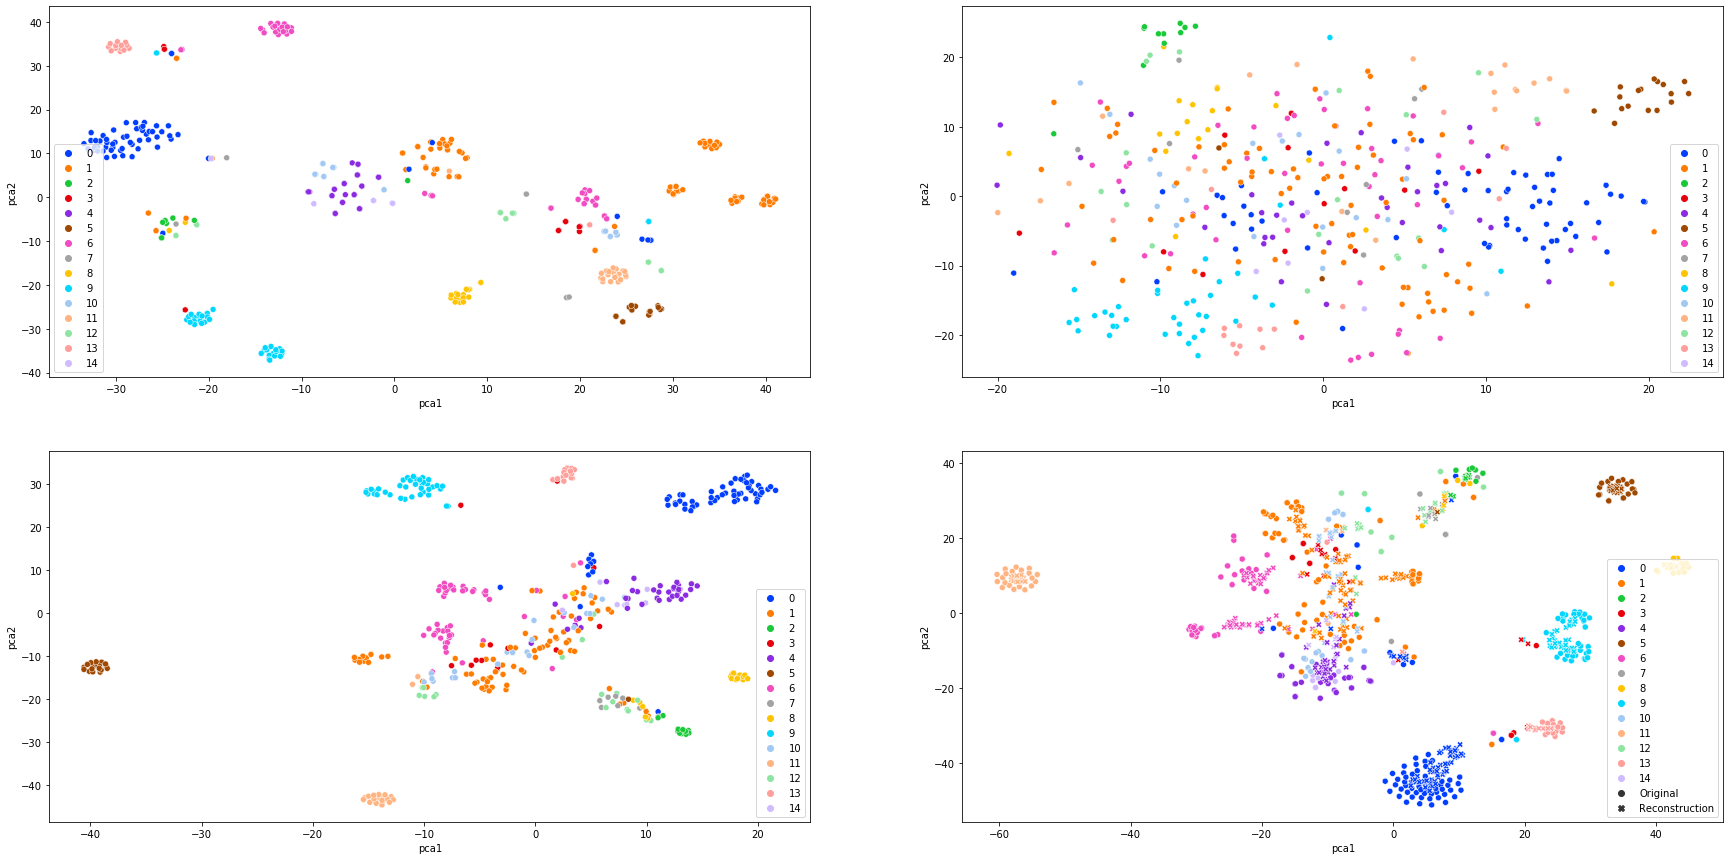

In [54]:
fig, ax = plt.subplots(2,2, figsize=(30,15))

pca = TSNE(perplexity=20)

embeddings = pca.fit_transform(X_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[0][0], palette=colors)

embeddings = pca.fit_transform(encodings_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[0][1], palette=colors)

embeddings = pca.fit_transform(reconstructed_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[1][0], palette=colors)

embeddings = pca.fit_transform(pd.concat([pd.DataFrame(X_train), pd.DataFrame(reconstructed_train)]))
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = np.array(list(y_train)+list(y_train)), ax=ax[1][1], palette=colors, style = ["Original"]*414+["Reconstruction"]*414)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

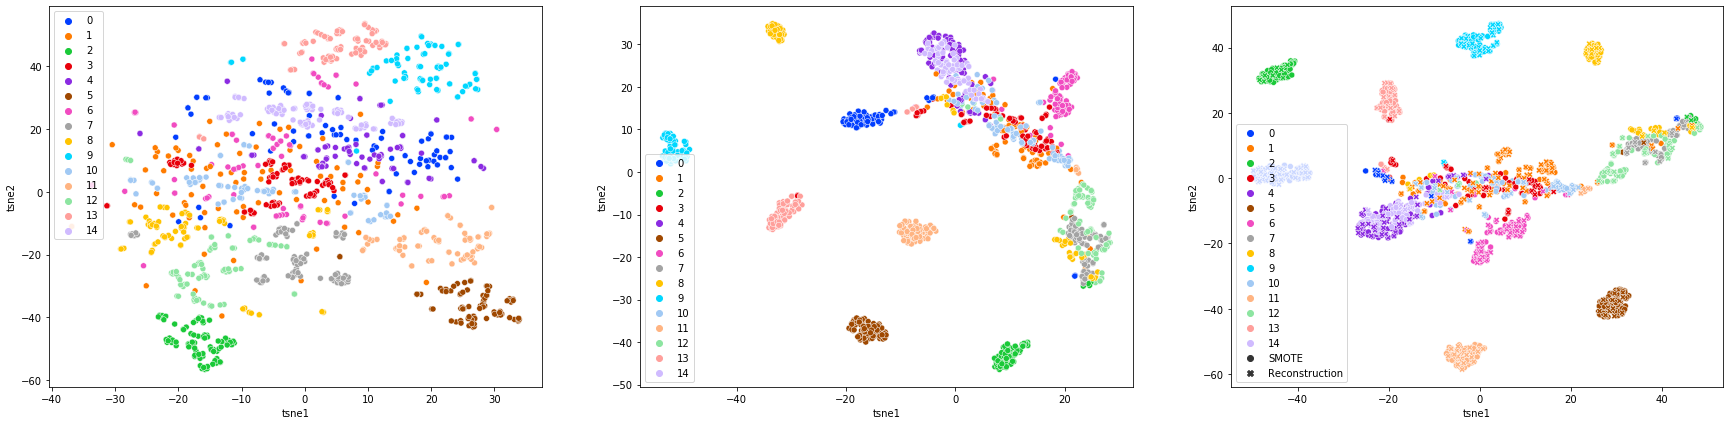

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [62]:
# Smote more samples in the latent space
encodings_smote, y_train_smote = SMOTETomek().fit_resample(encodings_train, y_train)

reconstructed_smote = decodeBatch(denoising_vae, encodings_smote)

fig, ax = plt.subplots(1,3, figsize=(30,7))

pca = TSNE(perplexity=40)

embeddings = pca.fit_transform(encodings_smote)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["tsne1", "tsne2"]), x= "tsne1", y = "tsne2", hue = y_train_smote, ax=ax[0], palette=colors)

plt.figure(figsize=(10,10))
embeddings = pca.fit_transform(reconstructed_smote)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["tsne1", "tsne2"]), x= "tsne1", y = "tsne2", hue = y_train_smote, ax=ax[1], palette=colors)

plt.figure(figsize=(10,10))
embeddings = pca.fit_transform(pd.concat([pd.DataFrame(reconstructed_smote), pd.DataFrame(reconstructed_train)]))
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["tsne1", "tsne2"]), x= "tsne1", y = "tsne2", hue = list(y_train_smote) + list(y_train), ax=ax[2], palette=colors, style = ["SMOTE"]*len(reconstructed_smote) + ["Reconstruction"]*414)

In [63]:
encodings_test, reconstructed_test = useVAE(denoising_vae, X_test)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

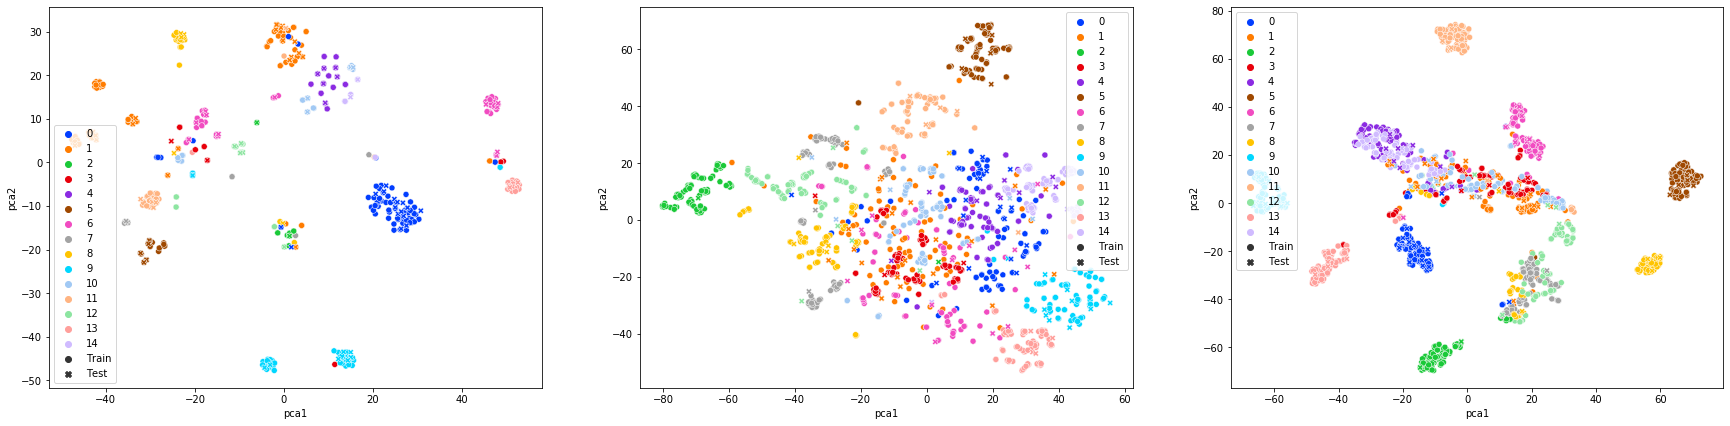

In [67]:
pca = TSNE(perplexity=20)

fig, ax = plt.subplots(1,3, figsize=(30,7))

embeddings = pca.fit_transform(pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_test)]))
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = np.array(list(y_train)+list(y_test)), ax=ax[0], palette=colors, style = ["Train"]*414+["Test"]*104)

embeddings = pca.fit_transform(pd.concat([pd.DataFrame(encodings_smote), pd.DataFrame(encodings_test)]))
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = np.array(list(y_train_smote)+list(y_test)), ax=ax[1], palette=colors, style = ["Train"]*len(y_train_smote)+["Test"]*104)

embeddings = pca.fit_transform(pd.concat([pd.DataFrame(reconstructed_smote), pd.DataFrame(reconstructed_test)]))
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = np.array(list(y_train_smote)+list(y_test)), ax=ax[2], palette=colors, style = ["Train"]*len(y_train_smote)+["Test"]*104)

In [35]:
meta.groupby(["Group"]).cell_line.unique()

Group
CRC                                  [HCT116, HT29, CRC, Colo-205, KM12, SW527]
Ductal_breast                 [MCF7, ZR751, SKBR3, MDA-MB-231, MDA-MB-453, M...
HCC                                                      [Hep3B, MHCC97, HepG2]
HEK293                                                                 [HEK293]
HGSOC                         [TYKNU, KURAMOCHI, SNU119, TYKNUCP, 59M, CAOV3...
HUVEC                                                                   [HUVEC]
HeLa                                                                     [HeLa]
Lymphoid_leukemia                                     [JVM13, Jurkat, CCRF-CEM]
Myeloid_leukemia                                             [K562, KO52, THP1]
Neuroblastoma                                            [LAN5, SHSY5Y, SKNBE2]
OV_endometrioid                                        [A2780, TOV112D, IGROV1]
SCC                                                             [A431, HCC1806]
glioblastoma                      

In [34]:
pd.DataFrame({"label":target_encoder.inverse_transform(list(range(15))), "code": list(range(15))})

label  code
0                          CRC     0
1                Ductal_breast     1
2                          HCC     2
3                       HEK293     3
4                        HGSOC     4
5                        HUVEC     5
6                         HeLa     6
7            Lymphoid_leukemia     7
8             Myeloid_leukemia     8
9                Neuroblastoma     9
10             OV_endometrioid    10
11                         SCC    11
12                glioblastoma    12
13                        iPSC    13
14  ovarian_cystadenocarcinoma    14

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

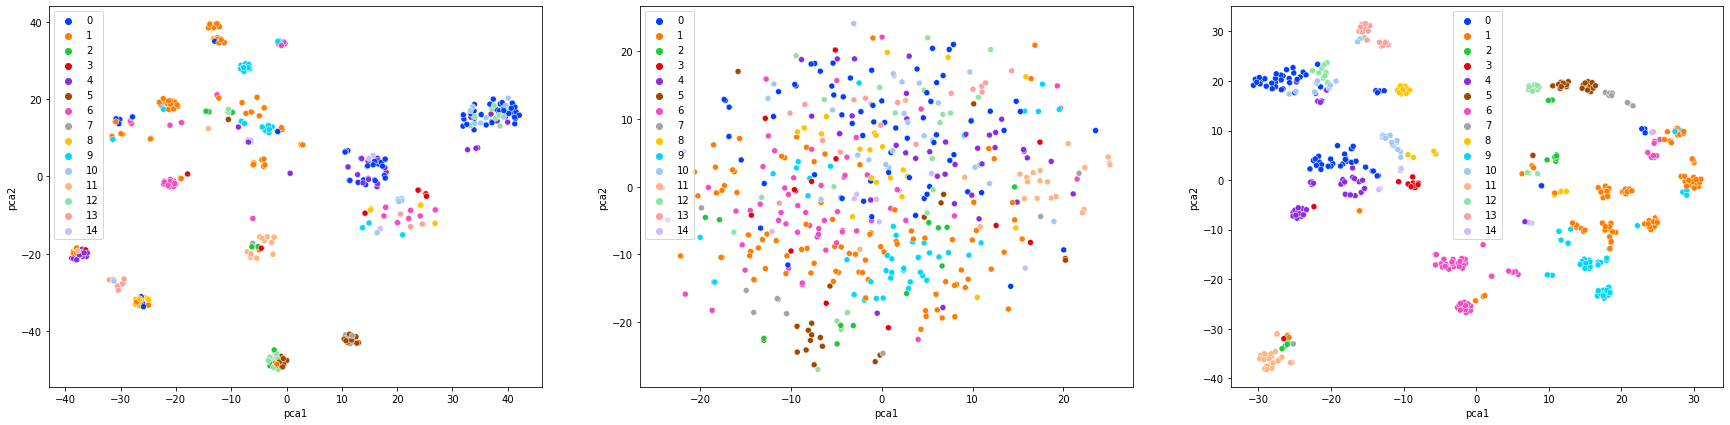

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(30,7))

pca = TSNE(perplexity=20)

embeddings = pca.fit_transform(X_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[0], palette=colors)

embeddings = pca.fit_transform(encodings_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[1], palette=colors)

embeddings = pca.fit_transform(reconstructed_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[2], palette=colors)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

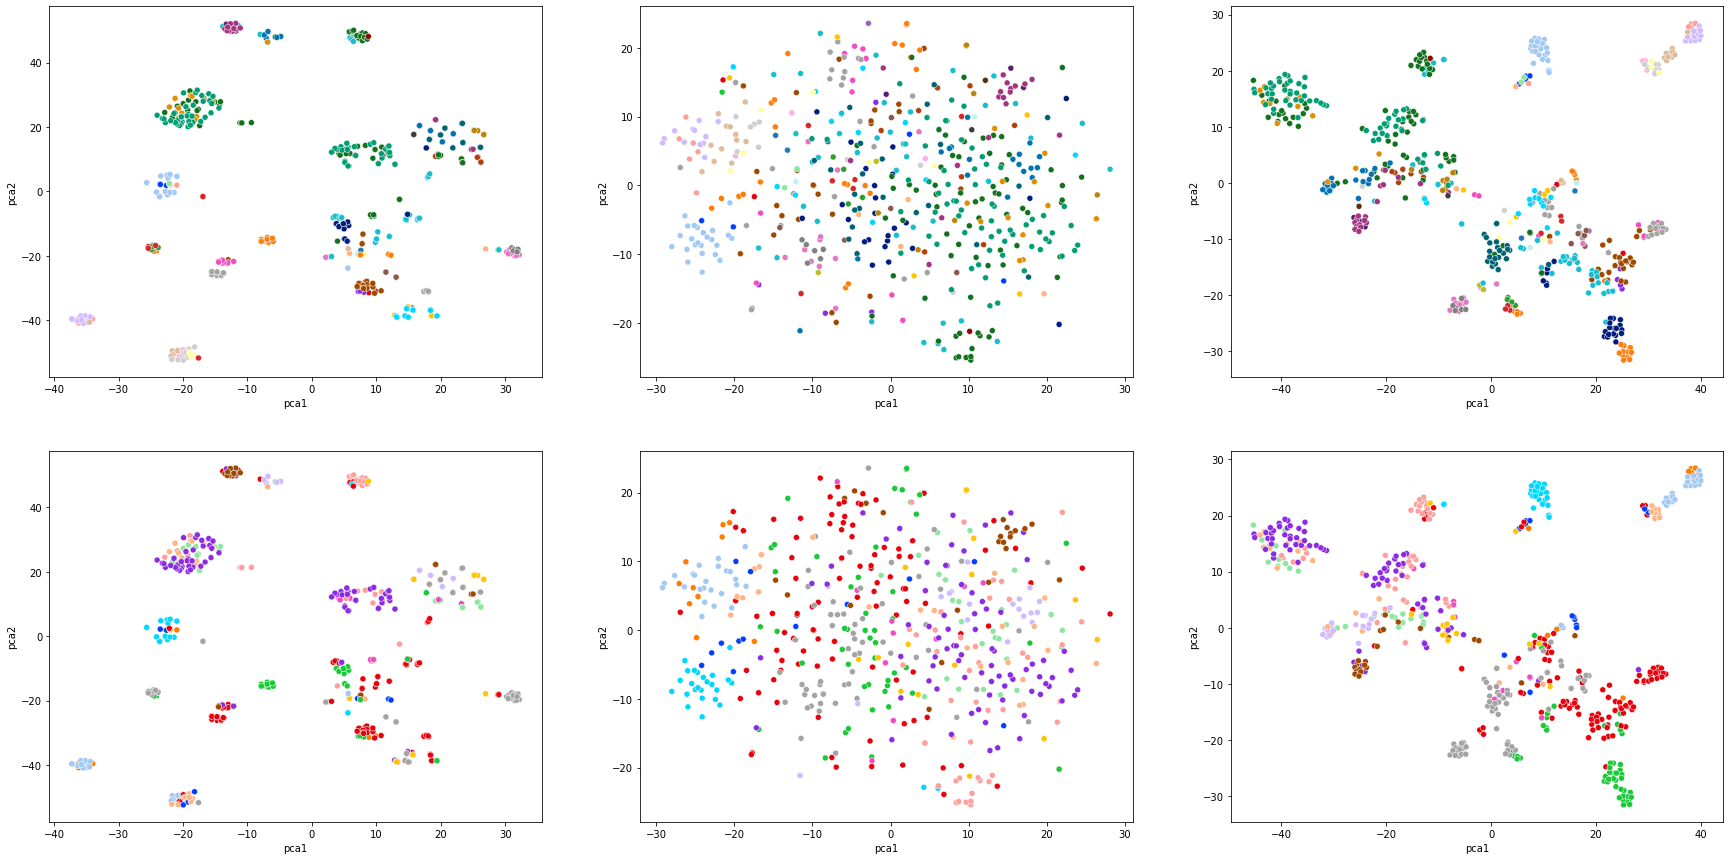

In [144]:
full_df_encoding, full_df_reconstructed = useVAE(denoising_vae, processed_data)

colors_pxd = sns.color_palette("bright")+sns.color_palette("pastel") + sns.color_palette("tab10") + sns.color_palette('dark') + sns.color_palette('colorblind')
colors_pxd = colors_pxd[:43]

fig, ax = plt.subplots(2,3, figsize=(30,15))

pca = TSNE(perplexity=20)

embeddings = pca.fit_transform(processed_data)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.PXD_accession.tolist(), ax=ax[0,0], palette=colors_pxd, legend=False)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.Group.tolist(), ax=ax[1,0], palette=colors, legend=False)

embeddings = pca.fit_transform(full_df_encoding)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.PXD_accession.tolist(), ax=ax[0,1], palette=colors_pxd, legend=False)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.Group.tolist(), ax=ax[1,1], palette=colors, legend=False)

embeddings = pca.fit_transform(full_df_reconstructed)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.PXD_accession.tolist(), ax=ax[0,2], palette=colors_pxd, legend=False)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.Group.tolist(), ax=ax[1,2], palette=colors, legend=False)

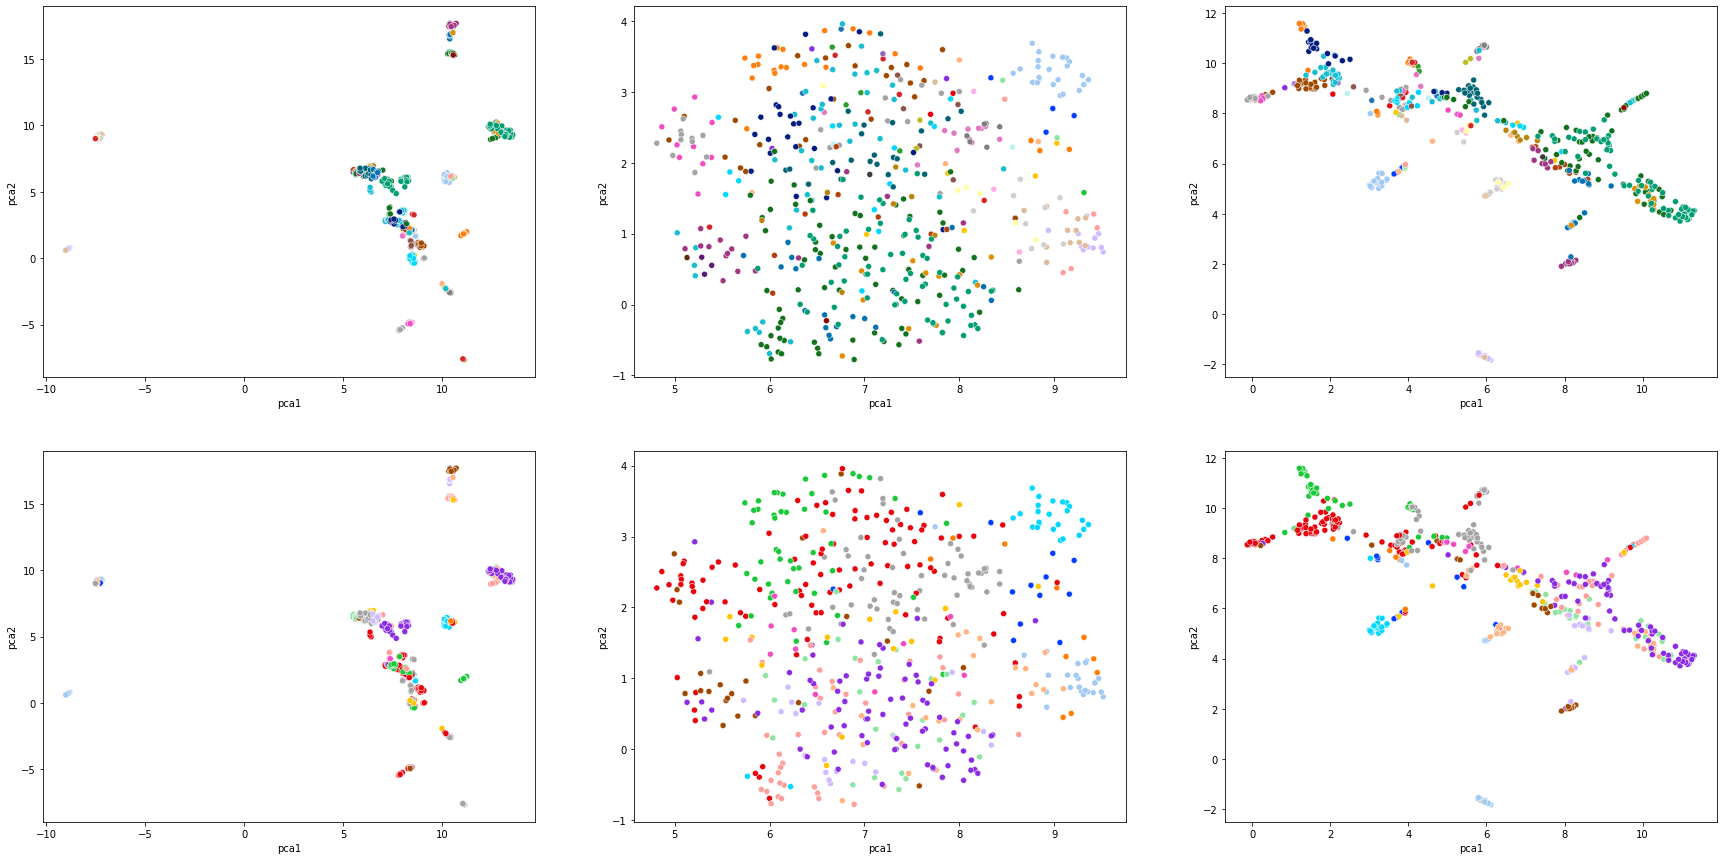

In [147]:
full_df_encoding, full_df_reconstructed = useVAE(denoising_vae, processed_data)

colors_pxd = sns.color_palette("bright")+sns.color_palette("pastel") + sns.color_palette("tab10") + sns.color_palette('dark') + sns.color_palette('colorblind')
colors_pxd = colors_pxd[:43]

fig, ax = plt.subplots(2,3, figsize=(30,15))

pca = UMAP(n_neighbors=50)

embeddings = pca.fit_transform(processed_data)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.PXD_accession.tolist(), ax=ax[0,0], palette=colors_pxd, legend=False)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.Group.tolist(), ax=ax[1,0], palette=colors, legend=False)

embeddings = pca.fit_transform(full_df_encoding)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.PXD_accession.tolist(), ax=ax[0,1], palette=colors_pxd, legend=False)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.Group.tolist(), ax=ax[1,1], palette=colors, legend=False)

embeddings = pca.fit_transform(full_df_reconstructed)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.PXD_accession.tolist(), ax=ax[0,2], palette=colors_pxd, legend=False)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = meta.Group.tolist(), ax=ax[1,2], palette=colors, legend=False)

In [15]:
# How do test samples regularize?

encodings_test, reconstructed_test = useVAE(denoising_vae, X_test)

In [16]:
y_train_df = pd.DataFrame(y_train, columns=["label"])
y_train_df["type"] = "train"

y_test_df = pd.DataFrame(y_test, columns=["label"])
y_test_df["type"] = "test"

y_train_test = pd.concat([y_train_df, y_test_df], axis=0).reset_index()

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

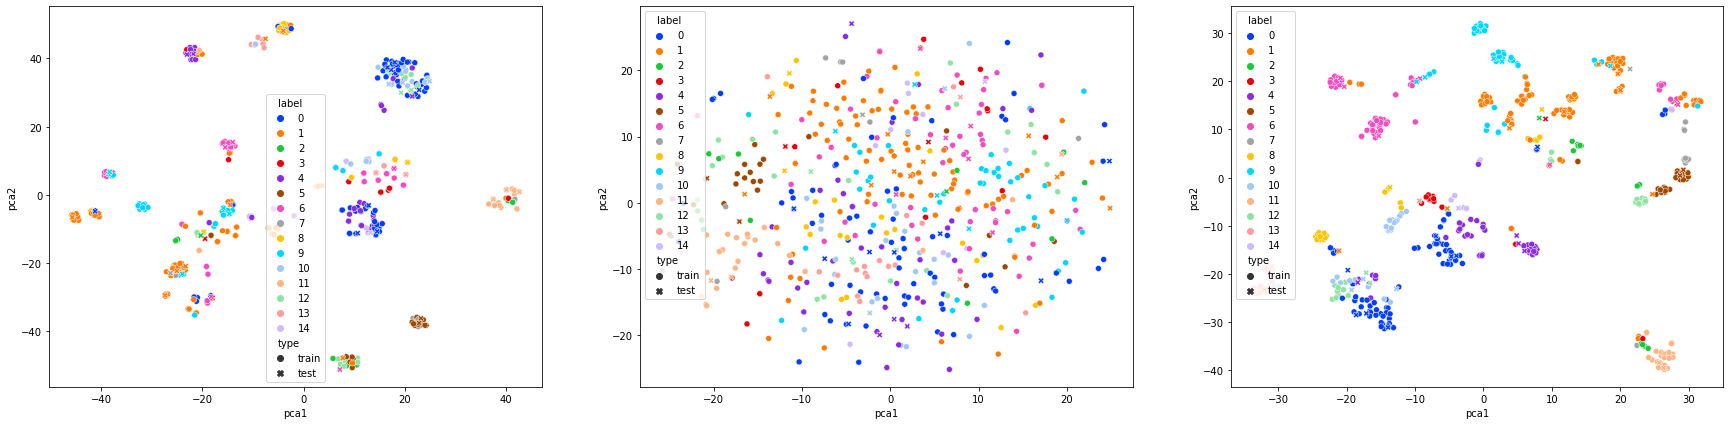

In [17]:
train_test = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_test)], axis=0)
encoded_train_test = pd.concat([pd.DataFrame(encodings_train), pd.DataFrame(encodings_test)], axis=0)
reconstructed_train_test = pd.concat([pd.DataFrame(reconstructed_train), pd.DataFrame(reconstructed_test)], axis=0)

fig, ax = plt.subplots(1,3, figsize=(30,7))

pca = TSNE(perplexity=20)

embeddings = pca.fit_transform(train_test)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train_test["label"], ax=ax[0], palette=colors, style = y_train_test["type"])

embeddings = pca.fit_transform(encoded_train_test)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train_test["label"], ax=ax[1], palette=colors, style = y_train_test["type"])

embeddings = pca.fit_transform(reconstructed_train_test)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train_test["label"], ax=ax[2], palette=colors, style = y_train_test["type"])

In [18]:
# Smote more samples in the latent space
encodings_smote, y_train_smote = SMOTETomek().fit_resample(encodings_train, y_train)

reconstructed_smote = decodeBatch(denoising_vae, encodings_smote)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


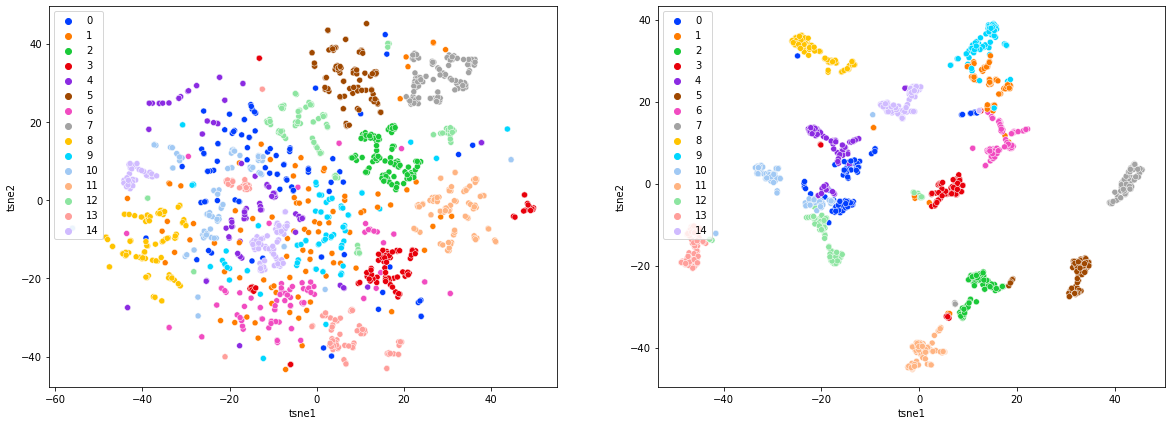

<Figure size 720x720 with 0 Axes>

In [19]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

pca = TSNE(perplexity=40)

embeddings = pca.fit_transform(encodings_smote)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["tsne1", "tsne2"]), x= "tsne1", y = "tsne2", hue = y_train_smote, ax=ax[0], palette=colors)

plt.figure(figsize=(10,10))
embeddings = pca.fit_transform(reconstructed_smote)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["tsne1", "tsne2"]), x= "tsne1", y = "tsne2", hue = y_train_smote, ax=ax[1], palette=colors)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


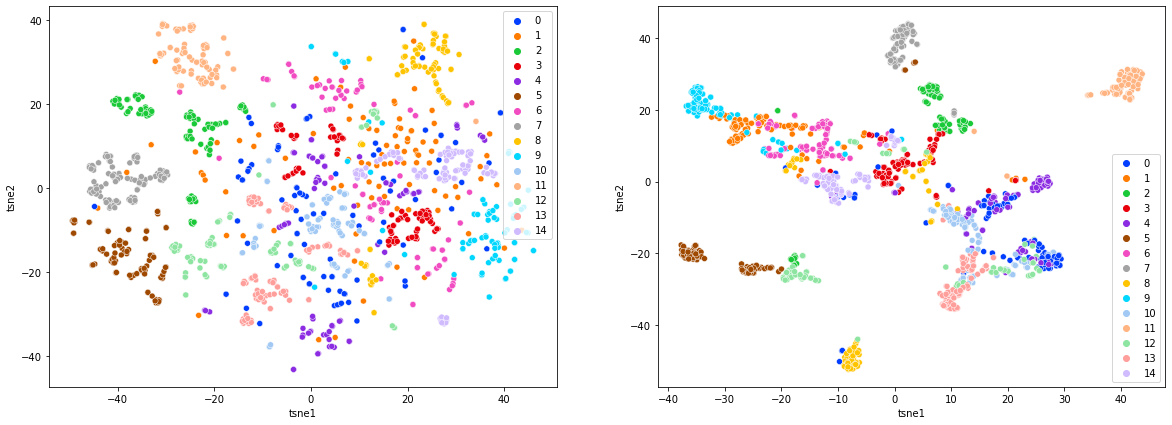

<Figure size 720x720 with 0 Axes>

In [127]:
# previous figure

fig, ax = plt.subplots(1,2, figsize=(20,7))

pca = TSNE(perplexity=40)

embeddings = pca.fit_transform(encodings_smote)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["tsne1", "tsne2"]), x= "tsne1", y = "tsne2", hue = y_train_smote, ax=ax[0], palette=colors)

plt.figure(figsize=(10,10))
embeddings = pca.fit_transform(reconstructed_smote)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["tsne1", "tsne2"]), x= "tsne1", y = "tsne2", hue = y_train_smote, ax=ax[1], palette=colors)

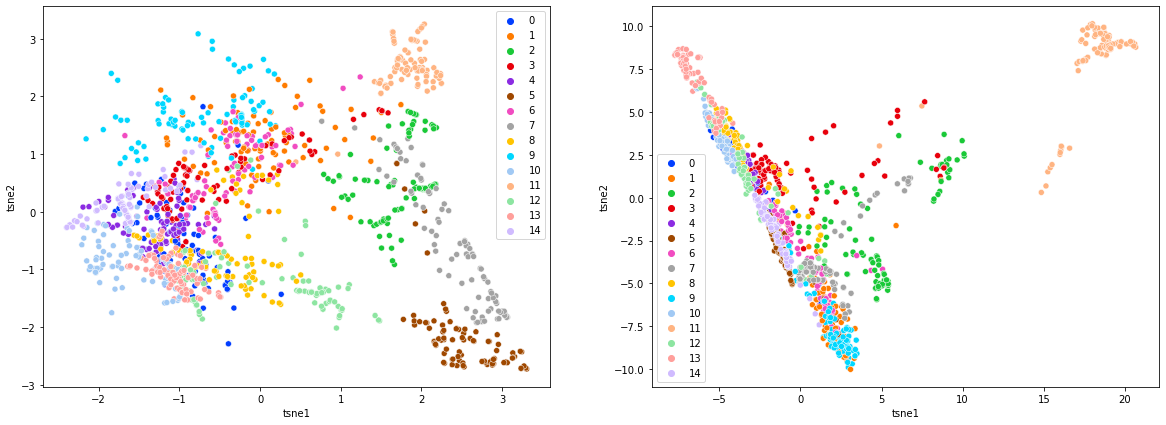

<Figure size 720x720 with 0 Axes>

In [62]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

pca = PCA(n_components=2)

embeddings = pca.fit_transform(encodings_smote)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["tsne1", "tsne2"]), x= "tsne1", y = "tsne2", hue = y_train_smote, ax=ax[0], palette=colors)

plt.figure(figsize=(10,10))
embeddings = pca.fit_transform(reconstructed_smote)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["tsne1", "tsne2"]), x= "tsne1", y = "tsne2", hue = y_train_smote, ax=ax[1], palette=colors)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

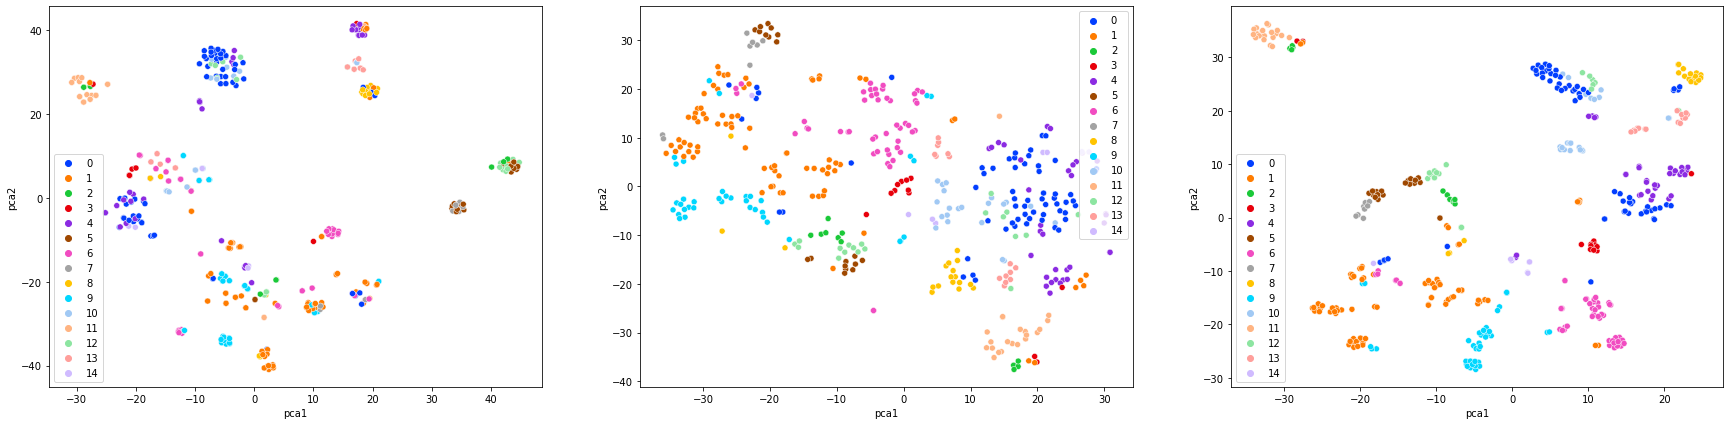

In [77]:
fig, ax = plt.subplots(1,3, figsize=(30,7))

pca = TSNE(perplexity=20)

embeddings = pca.fit_transform(X_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[0], palette=colors)

embeddings = pca.fit_transform(encodings_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[1], palette=colors)

embeddings = pca.fit_transform(reconstructed_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[2], palette=colors)

How are the latent variables distributed for generating one sample repeatedly? Is the kullback leibler divergence loss term doing its job?

In [26]:
encodings, reconstructions = SampleVAE(denoising_vae, [X_train[2]], 1000)

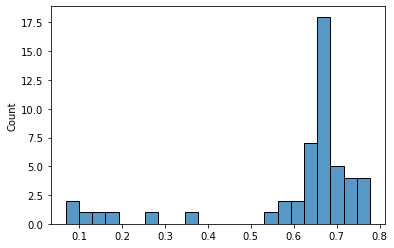

In [27]:
sns.histplot(pd.DataFrame(encodings).std())

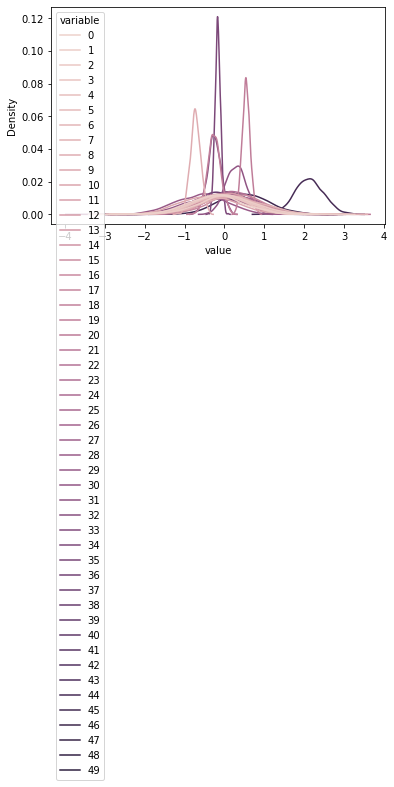

In [28]:
sns.kdeplot(data=pd.DataFrame(encodings).melt(), x='value' ,hue='variable', common_norm=True)

---

# Does this help with classification performance?

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

models = [LogisticRegression(max_iter=10000), SVC(), RandomForestClassifier()]
skf = StratifiedKFold(n_splits=10, shuffle=True)

fold=0
for train, test in skf.split(X=data, y=targets):
    fold += 1
    
    # Split data
    X_train = data.iloc[train,:]
    Y_train = targets[train]
    X_test = data.iloc[test,:]
    Y_test = targets[test]

    preprocessor.fit(X_train)
    X_train_preprocessed = preprocessor.transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Train autoencoder on train data
    vae_test = VariationalAutoencoder(50)
    vae_test, _, _ = trainDVAE2(vae_test, X_train_preprocessed, epochs=50)

    # Oversample on training set latent space
    train_encoded, train_reconstruction = useVAE(vae_test, X_train_preprocessed)
    train_oversample_encoded, y_train_oversample = SMOTETomek().fit_resample(train_encoded, Y_train)

    # Reconstruct datapoints from the oversampled encodings
    train_reconstructed_smote = decodeBatch(denoising_vae, train_oversample_encoded)

    for model in models:
        model.fit(train_reconstructed_smote, y_train_oversample)
        
        # Get prediction for original and reconstructed test samples
        test_encoding, test_reconstructed = useVAE(vae_test, X_test_preprocessed)
        Y_pred_original = model.predict(X_test_preprocessed)
        Y_pred_reconstruction = model.predict(test_reconstructed)

        micro_f1, macro_f1, weighted_f1, cm = uml.scoring_functions(Y_pred=Y_pred_original, 
                                                                    Y_test=Y_test,
                                                                    labels=unique_labels)

        results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm], "prediction": ["original"],
                                        "oversampler": ["VAE/SMOTETomek"]})
            
        uml.save_results(results_df, "VAE_evaluation")        
        
        results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1] ,"cm": [cm], "prediction": ["reconstruction"],
                                        "oversampler": ["VAE/SMOTETomek"]})
            
        uml.save_results(results_df, "VAE_evaluation")        


---

---

In [129]:
encodings_test, reconstructed_test = useVAE(denoising_vae, X_test)

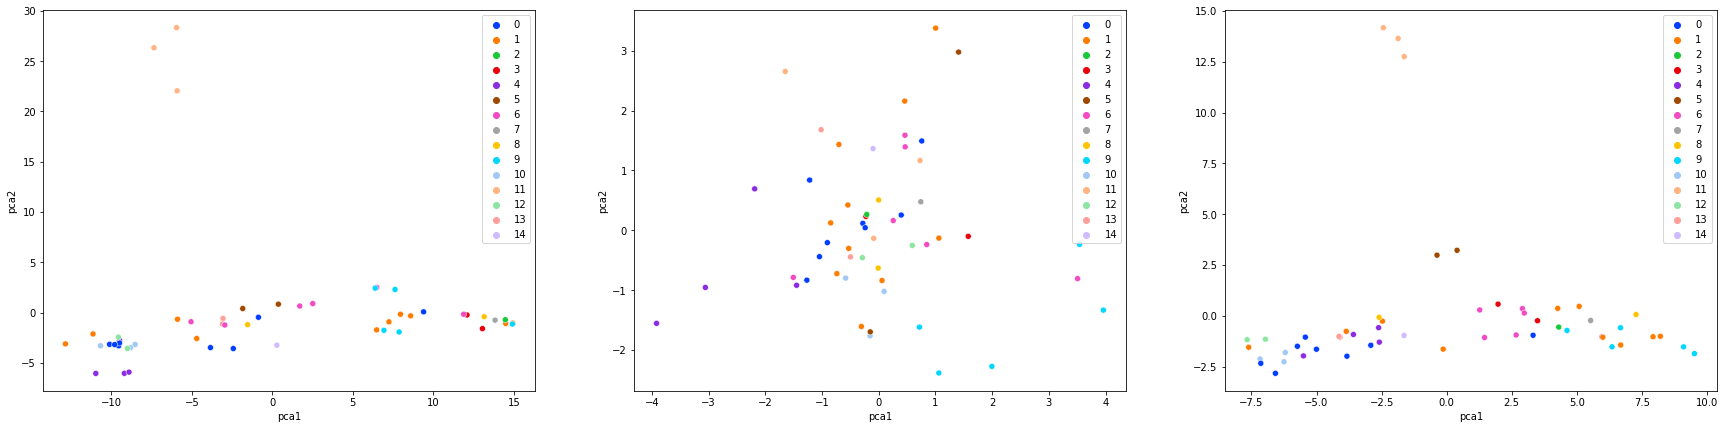

In [130]:
fig, ax = plt.subplots(1,3, figsize=(30,7))

pca = PCA(n_components=2)

embeddings = pca.fit_transform(X_test)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_test, ax=ax[0], palette=colors)

embeddings = pca.fit_transform(encodings_test)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_test, ax=ax[1], palette=colors)

embeddings = pca.fit_transform(reconstructed_test)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_test, ax=ax[2], palette=colors)

How different is are the latent variables for the same sample. Is is too discrete?

In [65]:
hela_breast = meta[meta.Group.isin(["HeLa", "Ductal_breast"])]

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


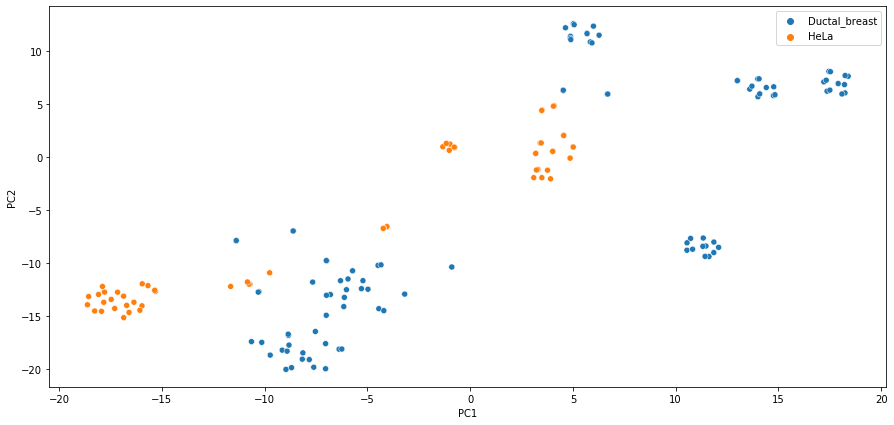

In [68]:
pca = TSNE(perplexity=20)

embeddings = pca.fit_transform(processed_data_df.loc[hela_breast.index, :])

plt.figure(figsize=(15,7))
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = hela_breast.Group.tolist())

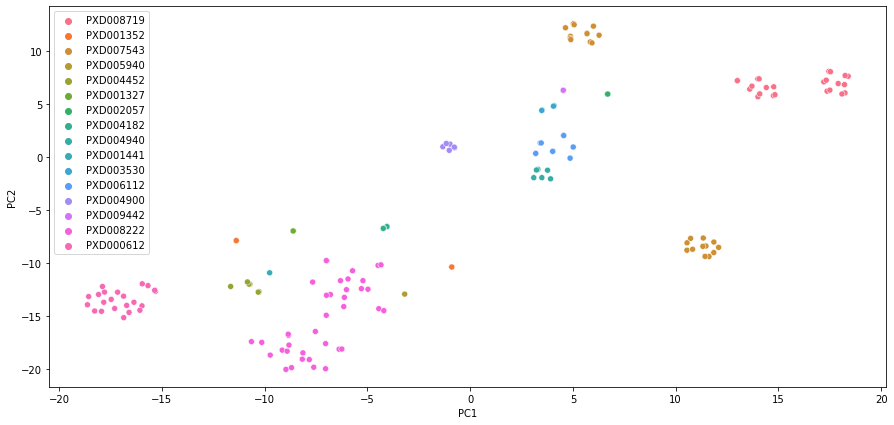

In [70]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = hela_breast.PXD_accession.tolist())

In [106]:
X_train, X_test, y_train, y_test = train_test_split(processed_data, targets, test_size=0.20, random_state=42, stratify=targets)

In [107]:
train_data = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

In [108]:
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=10)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=10)

In [113]:
vae = VariationalAutoencoder(20)

In [116]:
vae, training_loss, validation_loss = trainDVAE2(vae, dataloader_train, dataloader_test, 10)

  epoch 0 loss: 167.953265848943
     Validation loss: 163.95767409984882

  epoch 1 loss: 156.77086031264153
     Validation loss: 149.9747409086961

  epoch 2 loss: 145.54097727531396
     Validation loss: 137.47568680689886



KeyboardInterrupt: 

In [111]:
#dataloader_bs1 = torch.utils.data.DataLoader(processed_data, batch_size = 1, shuffle=False)

In [234]:
vae = trainVAE(vae, dataloader, epochs = 30)

0
tensor(767.3354, grad_fn=<AddBackward0>)
1
tensor(865.1193, grad_fn=<AddBackward0>)
2
tensor(844.0660, grad_fn=<AddBackward0>)
3
tensor(881.5931, grad_fn=<AddBackward0>)
4
tensor(941.1876, grad_fn=<AddBackward0>)
5
tensor(697.2341, grad_fn=<AddBackward0>)
6
tensor(600.4299, grad_fn=<AddBackward0>)
7
tensor(675.9283, grad_fn=<AddBackward0>)
8
tensor(728.9360, grad_fn=<AddBackward0>)
9
tensor(803.1388, grad_fn=<AddBackward0>)
10
tensor(922.8105, grad_fn=<AddBackward0>)
11
tensor(684.8820, grad_fn=<AddBackward0>)
12
tensor(667.9693, grad_fn=<AddBackward0>)
13
tensor(815.0889, grad_fn=<AddBackward0>)
14
tensor(613.2781, grad_fn=<AddBackward0>)
15
tensor(658.9448, grad_fn=<AddBackward0>)
16
tensor(812.0526, grad_fn=<AddBackward0>)
17
tensor(682.0793, grad_fn=<AddBackward0>)
18
tensor(742.8961, grad_fn=<AddBackward0>)
19
tensor(807.4932, grad_fn=<AddBackward0>)
20
tensor(582.9099, grad_fn=<AddBackward0>)
21
tensor(799.0953, grad_fn=<AddBackward0>)
22
tensor(808.1902, grad_fn=<AddBackward0>

In [29]:
neuroblast_data = processed_data_df.loc[meta[meta.Group == "Neuroblastoma"].index, :]

In [70]:
neuroblast_data.shape

(48, 2615)

In [ ]:
torch.utils.data.DataLoader(processed_data, batch_size = 4, shuffle=True)

In [38]:
for x in dataloader:
    print(x.shape)
    break

torch.Size([4, 2615])


In [110]:
dataloader_neuro = torch.utils.data.DataLoader(neuroblast_data.to_numpy(), batch_size = 1)

In [121]:
flag = True
for neuro_sample in dataloader_neuro:
    
    neuro_sample = np.array(neuro_sample)
    neuro_sample = torch.Tensor(neuro_sample)

    if flag:
        neuro_encodings = vae.encoder(neuro_sample).detach().numpy()[0]
        flag = False
        continue
    
    neuro_encodings = np.vstack([neuro_encodings, vae.encoder(neuro_sample).detach().numpy()[0]])

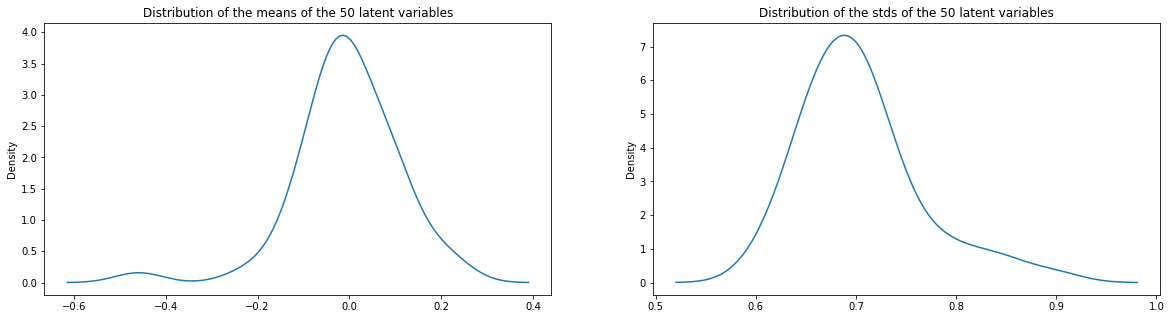

In [122]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].set_title("Distribution of the means of the 50 latent variables")
ax[1].set_title("Distribution of the stds of the 50 latent variables")

sns.kdeplot(pd.DataFrame(neuro_encodings).mean(), ax=ax[0])
sns.kdeplot(pd.DataFrame(neuro_encodings).std(), ax=ax[1])

In [99]:
norm_neuro_encodings = normalize(neuro_encodings)

In [102]:
neuro_encodings.min()

-2.2875586

IndexError: index 8 is out of bounds for axis 0 with size 8

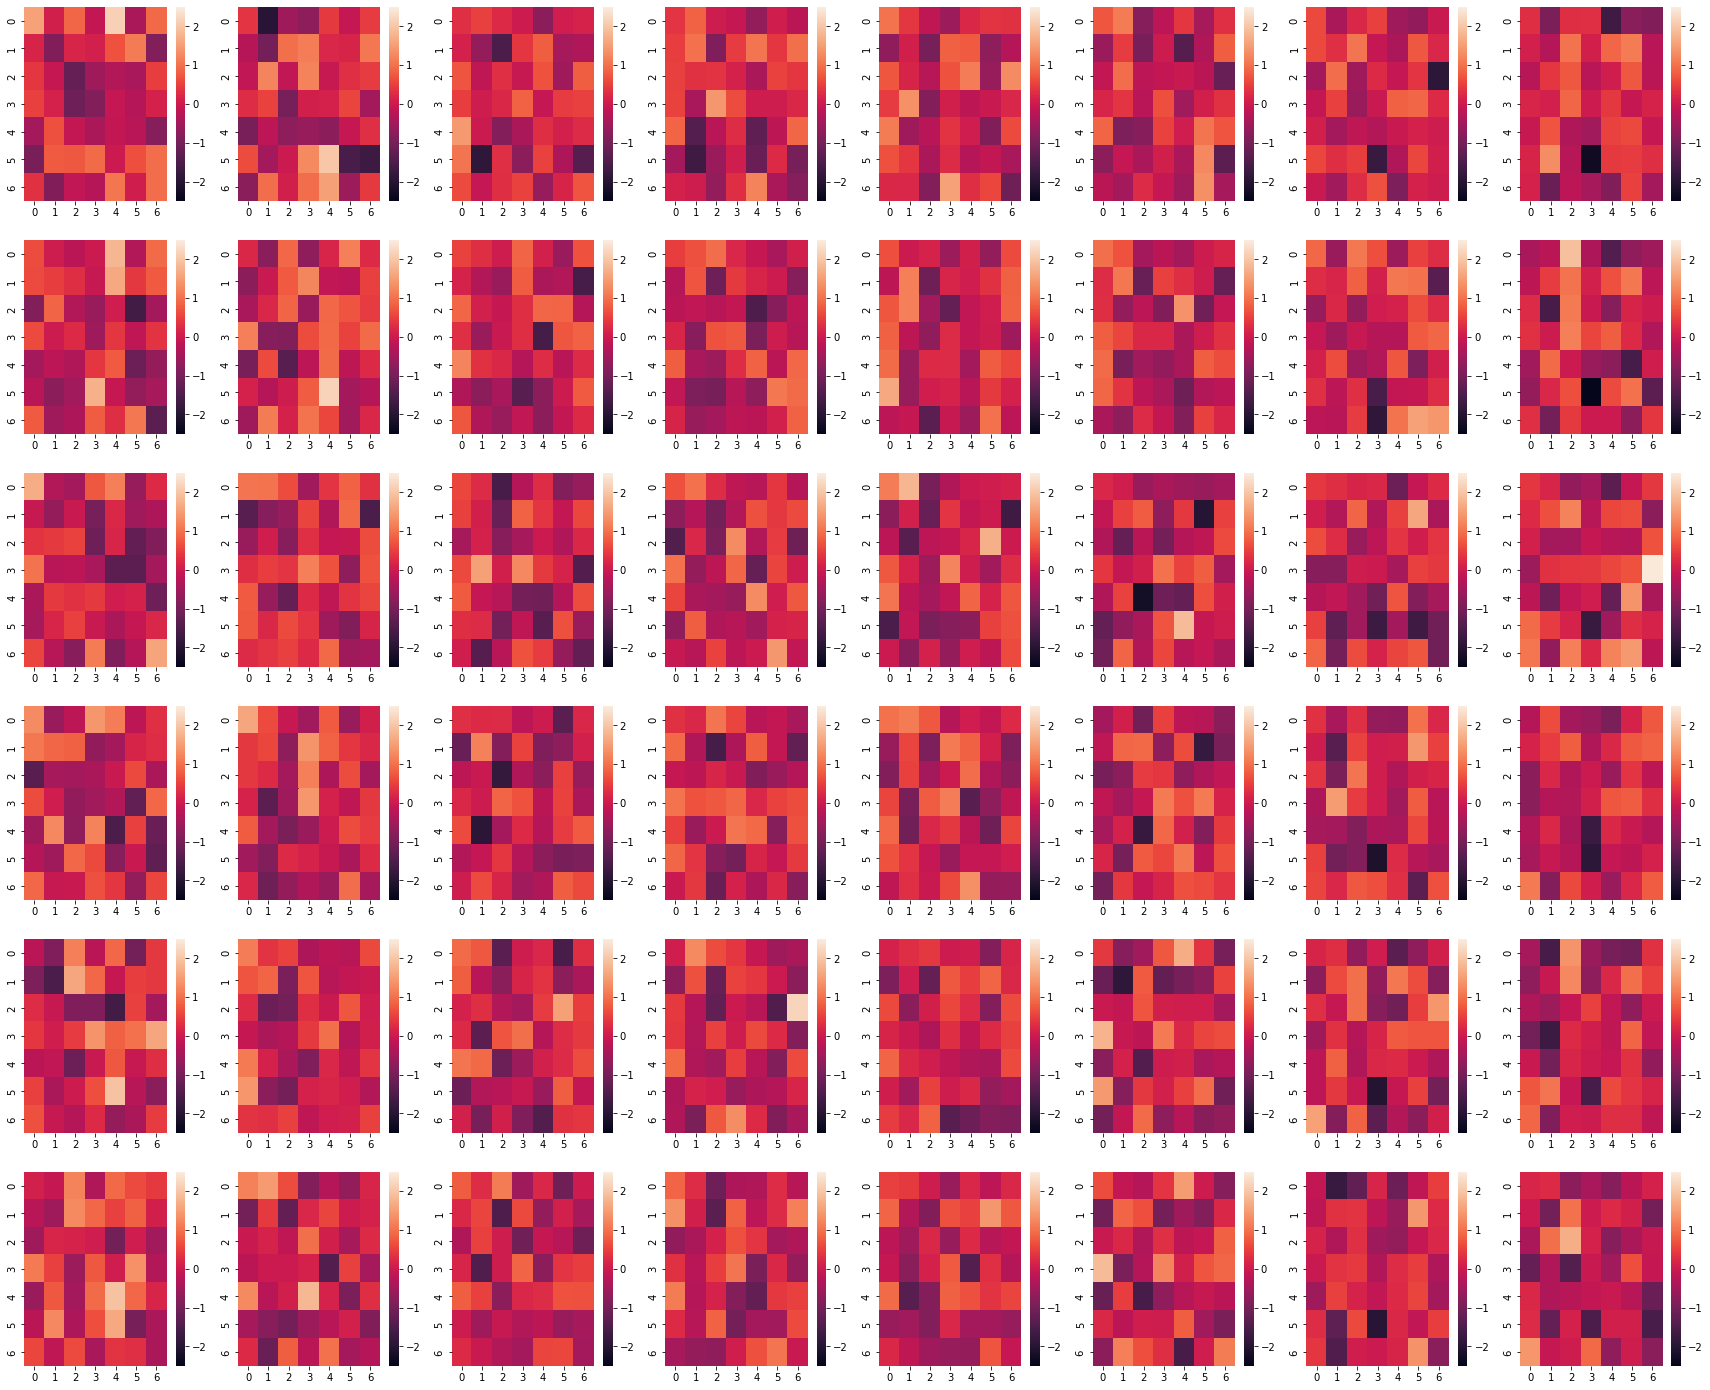

In [123]:
fig, ax = plt.subplots(6,8, figsize=(30,25))

row_i = 0
col_i = 0

for x in neuro_encodings:
    x = x.reshape(7,7)
    
    sns.heatmap(x, vmax=2.5, vmin=-2.5, ax=ax[row_i][col_i])

    row_i += 1
    if row_i == 6:
        col_i+=1
        row_i = 0
    

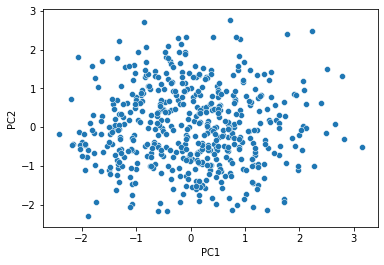

In [138]:
pca = PCA(n_components=2)

embeddings = pca.fit_transform(neuro_encodings)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2")

In [124]:
flag = True
for sample in dataloader_bs1:
    
    sample = np.array(sample)
    sample = torch.Tensor(sample)

    if flag:
        encodings = vae.encoder(sample).detach().numpy()[0]
        flag = False
        continue
    
    encodings = np.vstack([encodings, vae.encoder(sample).detach().numpy()[0]])

In [116]:
meta.Group

assay_id
30960    HCC
30961    HCC
31008    HCC
31009    HCC
31488    HCC
        ... 
36299    CRC
36344    CRC
36347    CRC
36350    CRC
36416    CRC
Name: Group, Length: 518, dtype: object

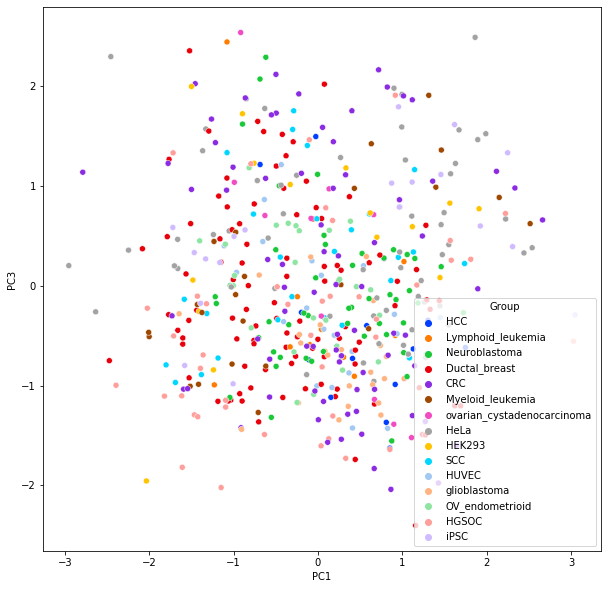

In [135]:
plt.figure(figsize=(10,10))

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

pca = PCA(n_components=3)

embeddings = pca.fit_transform(encodings)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["PC1", "PC2", "PC3"]), x= "PC1", y = "PC3", hue = meta.reset_index()["Group"], palette=colors)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


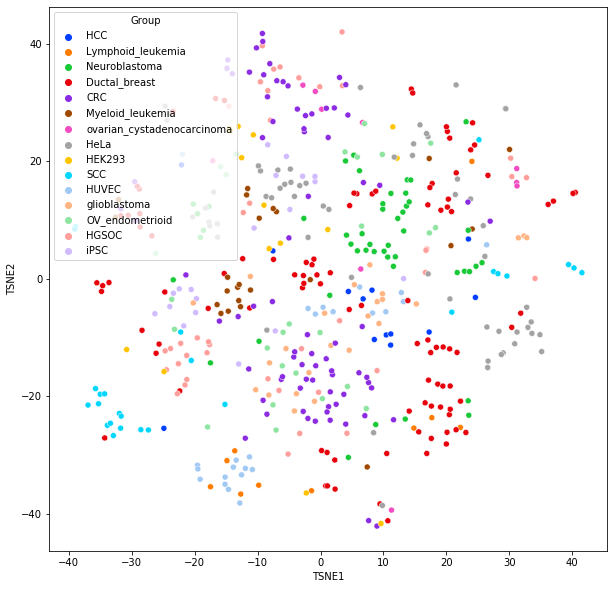

In [137]:
plt.figure(figsize=(10,10))

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

tsne = TSNE(perplexity=15)

embeddings = tsne.fit_transform(encodings)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette=colors)

How different are the samples after being reconstructed?

In [180]:
flag = True
for sample in dataloader_bs1:
    
    sample = np.array(sample)
    sample = torch.Tensor(sample)

    if flag:
        reconstructed_samples = vae.decoder(vae.encoder(sample)).detach().numpy()[0]
        flag = False
        continue
    
    reconstructed_samples = np.vstack([reconstructed_samples, vae.decoder(vae.encoder(sample)).detach().numpy()[0]])


In [185]:
reconstructions = pd.DataFrame(reconstructed_samples, columns= processed_data_df.columns)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


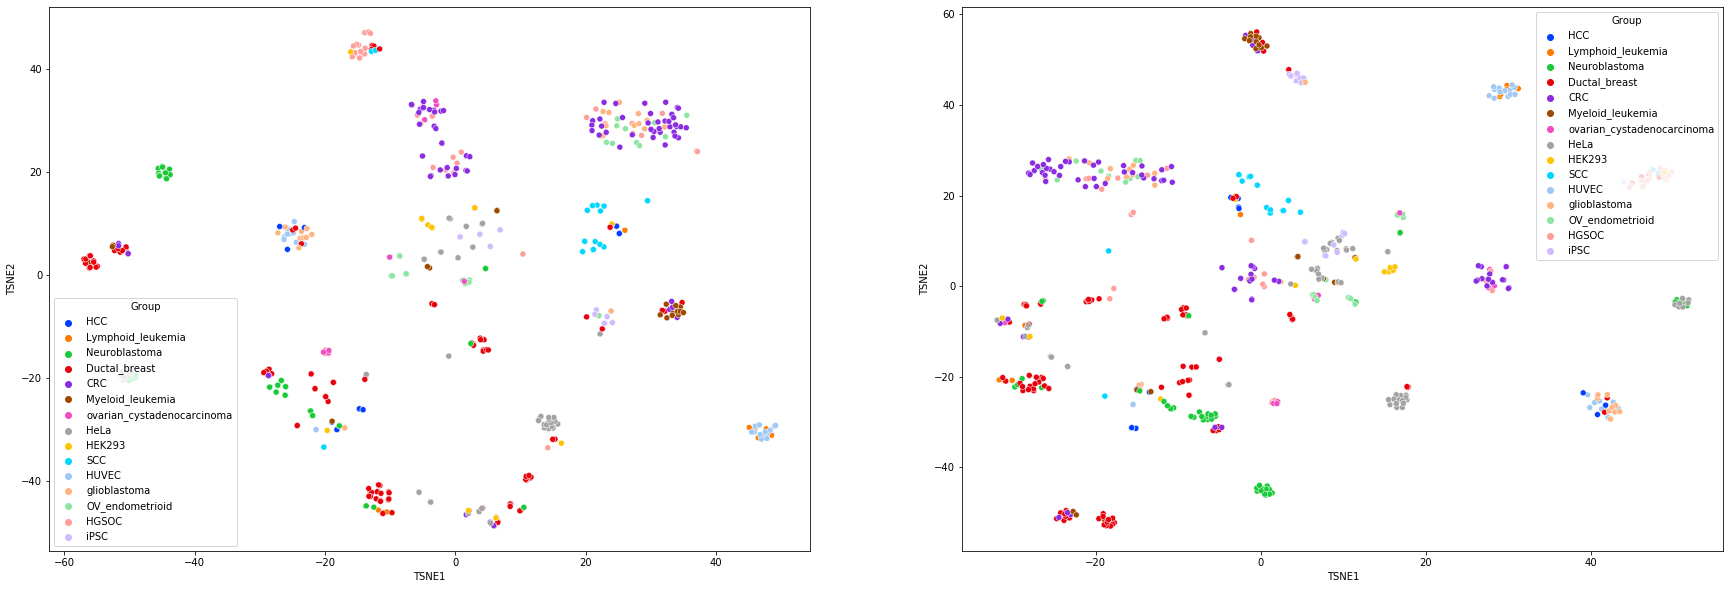

In [188]:
fig, ax = plt.subplots(1,2, figsize=(30,10))

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

tsne = TSNE(perplexity=15)

embeddings = tsne.fit_transform(processed_data_df)
embeddings_reconstructed = tsne.fit_transform(reconstructions)

sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette=colors, ax=ax[0])
sns.scatterplot(data=pd.DataFrame(embeddings_reconstructed, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette=colors, ax=ax[1])

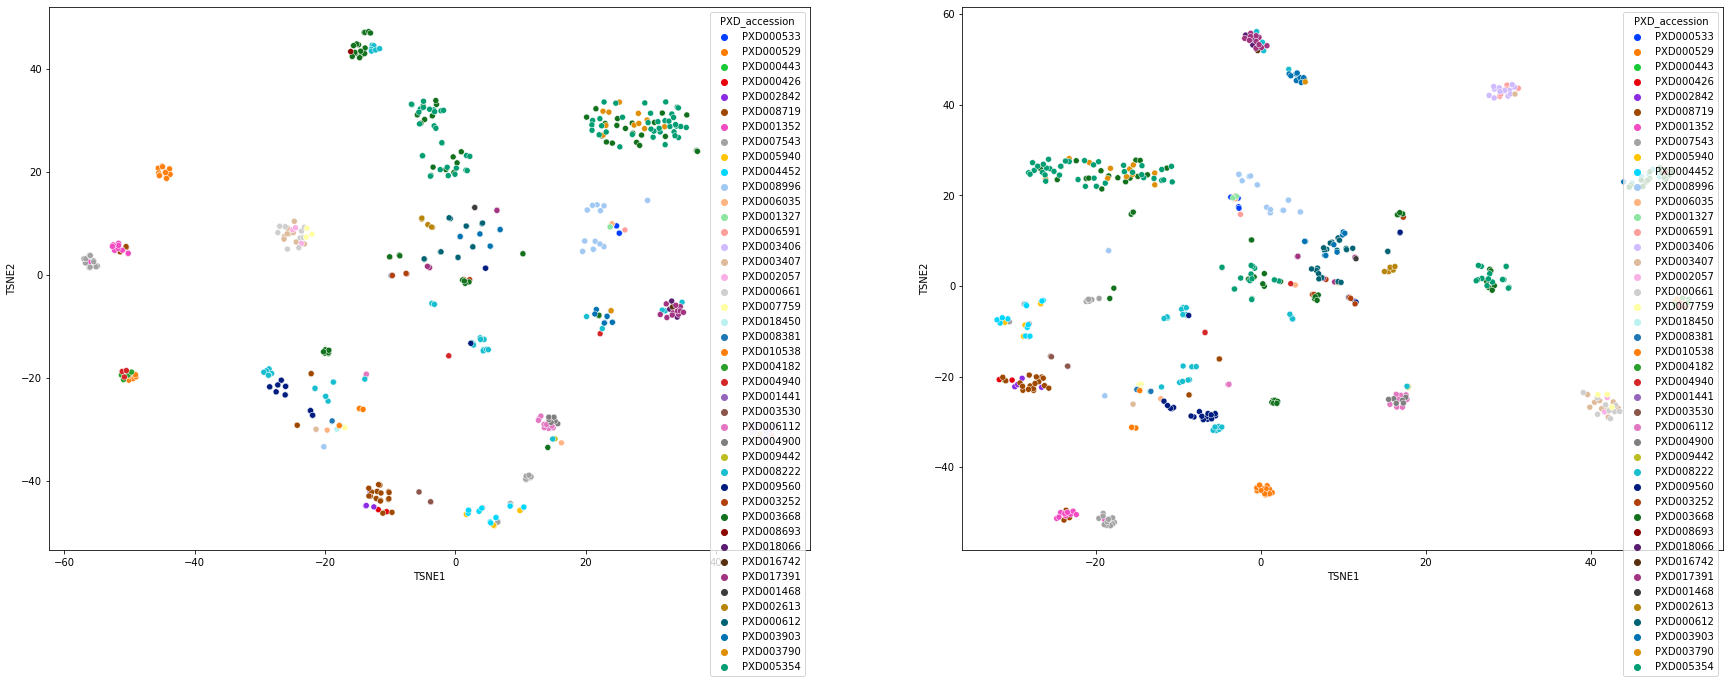

In [197]:
fig, ax = plt.subplots(1,2, figsize=(30,10))

colors = sns.color_palette("bright")+sns.color_palette("pastel") + sns.color_palette("tab10") + sns.color_palette('dark') + sns.color_palette('colorblind')
colors = colors[:43]

sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["PXD_accession"], palette = colors, ax=ax[0])
sns.scatterplot(data=pd.DataFrame(embeddings_reconstructed, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["PXD_accession"], palette=colors, ax=ax[1])

Check reconstruction of 1 sample

In [223]:
dataloader_neuro = torch.utils.data.DataLoader(neuroblast_data.to_numpy(), batch_size = 1, shuffle=False)

flag=True
for i, sample in enumerate(dataloader_neuro):

    if flag:
        reconstructed_samples = vae.decoder(vae.encoder(sample)).detach().numpy()[0]
        neuro_encodings = vae.encoder(sample).detach().numpy()[0]
        flag = False
        continue
    
    neuro_encodings = np.vstack([neuro_encodings, vae.encoder(sample).detach().numpy()[0]])
    reconstructed_samples = np.vstack([reconstructed_samples, vae.decoder(vae.encoder(sample)).detach().numpy()[0]])

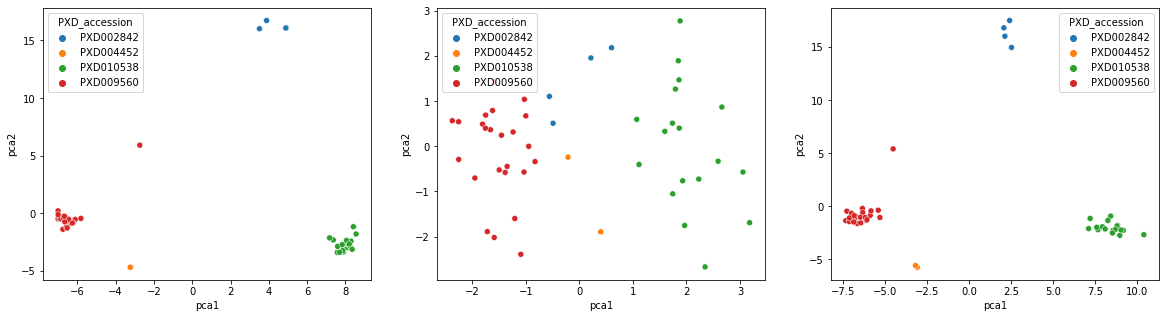

In [227]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

pca = PCA(n_components=2)

embeddings = pca.fit_transform(neuroblast_data)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"], index=neuroblast_data.index), x= "pca1", y = "pca2", hue = meta.loc[neuroblast_data.index,:].PXD_accession, ax=ax[0])

embeddings = pca.fit_transform(neuro_encodings)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"], index=neuroblast_data.index), x= "pca1", y = "pca2", hue = meta.loc[neuroblast_data.index,:].PXD_accession, ax=ax[1])

embeddings = pca.fit_transform(reconstructed_samples)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"], index=neuroblast_data.index), x= "pca1", y = "pca2", hue = meta.loc[neuroblast_data.index,:].PXD_accession, ax=ax[2])

---

In [ ]:
plt.figure(figsize=(10,10))

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

tsne = TSNE(perplexity=15)

embeddings = tsne.fit_transform(encodings)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette=colors)

In [141]:
meta[meta.Group == "Neuroblastoma"].index

Int64Index([31102, 31103, 31104, 31105, 35009, 35097, 31593, 31598, 31603,
            31608, 31613, 31618, 31623, 31628, 31633, 31638, 31643, 31648,
            31653, 31658, 31663, 31668, 31673, 31678, 31706, 31707, 31708,
            31709, 31710, 31711, 31712, 31725, 31726, 31727, 31728, 31729,
            31713, 31714, 31715, 31716, 31717, 31718, 31719, 31720, 31721,
            31722, 31723, 31724],
           dtype='int64', name='assay_id')

In [174]:
processed_data.shape

(518, 2615)

In [171]:
vae.decoder(vae.encoder(neuro_sample))

tensor([[4.6499e-01, 6.6831e-01, 1.9947e-04,  ..., 5.2189e-01, 7.2257e-02,
         2.3699e-02]], grad_fn=<SigmoidBackward0>)